Here we provide the codes writen in python used in the analysis presented in the paper 'Differential impact of self and environmental antigens on the ontogeny and maintenance of CD4$^+$ T cell memory' @ Elife, 2019.
<br>
File data_Elife_2019.xlsx is the master file containing all data used in this analysis.

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.integrate import odeint
from matplotlib import ticker
from scipy import stats
import matplotlib.lines as mlines
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

'''
In this section all insentives for plots are being set up.
'''
current_palette = sns.color_palette()
palette = sns.color_palette()
sns.set_style("whitegrid")

my_axis_fontsize = 20
my_lab_fontsize = 20
my_title_fontsize = 20

csfont = {'fontname':'Palatino'}
hfont = {'fontname':'Helvetica'}

matplotlib.rc('pdf', fonttype=42)

'''
File data_Elife_2019.xlsx is the master file containing all data used in this analysis.
Here we export that file to object called xls.
'''
xls = pd.ExcelFile('data_Elife_2019.xlsx')

# Fitting the splines to naive and central memory CD4 cell counts

In [17]:
'''
In this section we upload the sheet with data of the cell counts 
in the source of memory population,  naive CD4 and central memory CD4, 
and then we fit the splines to these data.   
'''

def import_data_source_cc_all(xls): 
    '''
    The function creates the dataframe from master file
    with cell counts of the source population (naive CD4 and central memory)
    from WT and chimeric mice from both facilities, UCL and NIMR.
    '''
    dfchimeras = xls.parse('WT and chimera cell counts for splines')
    dfchimeras = dfchimeras[['Location and mouse type','Mouse age (days)',
                             'Naive CD4 cell counts','Central memory CD4 cell counts']]
    # Rename the columns for simplicity
    dfchimeras.rename(columns = {'Location and mouse type':'exptlocation',
                                 'Mouse age (days)':'age',
                                 'Naive CD4 cell counts':'TotalNai4',
                                 'Central memory CD4 cell counts':'TotalTcm4'},
                      inplace=True)
    
    # Add some columns with log of total counts.
    # Later we will fit to log cell counts.
    for col in ['TotalNai4','TotalTcm4']:
        dfchimeras['log'+col] = np.log(dfchimeras[col].values)
    return(dfchimeras)

def getSourceDataCC(population, data):
    '''
    The function returns two dataframes for total cell counts 
    in source population of interest, naive ('Nai4') or central memory ('Tcm4') CD4,
    one for NIMR mice and the other for UCL mice.
    data = import_data_source_cc_all(xls)
    '''
    # NIMRindex is True for NIMR data
    NIMRChiIndex = data['exptlocation'] == 'NIMR chimera' 
    NIMRWTIndex = data['exptlocation'] == 'NIMR WT'
    NIMRindex = NIMRChiIndex | NIMRWTIndex
    
    # UCLindex is True for UCL data
    UCLChiIndex = data['exptlocation'] == 'UCL chimera'
    UCLWTIndex = data['exptlocation'] == 'UCL WT'
    UCLindex = UCLChiIndex | UCLWTIndex
    
    ddNIMR = data.copy()
    ddNIMR = ddNIMR.loc[NIMRindex, :]
    ddNIMR = ddNIMR.reset_index(drop=True)
    
    ddUCL = data.copy()
    ddUCL = ddUCL.loc[UCLindex, :]
    ddUCL = ddUCL.reset_index(drop=True)
    
    cols_of_interest = ['age', 'Total'+population, 'logTotal'+population]
    
    # popIndex is True for values for non-empty rows
    # as there are empty cells in central memory pool
    popIndex = np.logical_not(np.isnan(ddNIMR['Total'+population]))  
    CountNIMR = ddNIMR.copy()
    CountNIMR = CountNIMR.loc[popIndex, :]
    CountNIMR = CountNIMR.reset_index(drop=True) 
    CountNIMR = CountNIMR[cols_of_interest]

    popIndex = np.logical_not(np.isnan(ddUCL['Total'+population]))  
    CountUCL = ddUCL.copy()
    CountUCL = CountUCL.loc[popIndex, :]
    CountUCL = CountUCL.reset_index(drop=True) 
    CountUCL = CountUCL[cols_of_interest]
    return CountNIMR, CountUCL

In [18]:
'''
The table contains all data used for fitting the spline to cell counts 
in naive CD4 and central memory CD4 population.
'''
#import_data_source_cc_all(xls)

'\nThe table contains all data used for fitting the spline to cell counts \nin naive CD4 and central memory CD4 population.\n'

Naive T cell numbers, and memory cell numbers in dirty mice, were modeled with exponential decay ($S(t)  = S_\text{max} e^{-r t}$); memory cell numbers in clean mice were described with $S(t) = S_\text{max}/(1+ e^{-rt}(S_\text{max}-S_\text{min})/S_\text{min})$. 

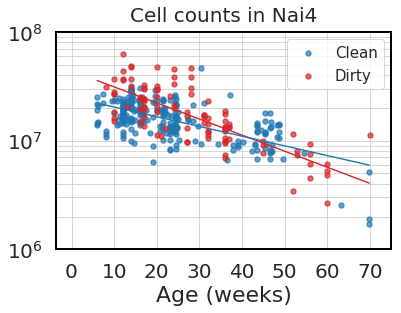

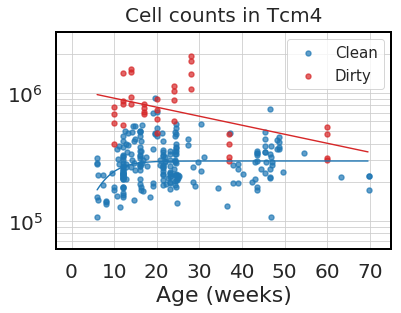

In [19]:
'''
In this section we fit the source cell counts to exponential or logistic function.
Naive CD4 UCL/NIMR - exponencial
Tcm4 UCL - logistic
Tcm4 NIMR - exponencial
'''

def expModel(params, t):
    '''
    The function defines exponential decay.
    '''
    t = np.array(t)
    Smax = params[0]
    r = params[1]
    expv = np.array(-1.*t*r)
    return Smax*np.exp(expv.astype(float))

def logModel(params, t):
    '''
    The function defines the logistic grow.
    '''
    t = np.array(t)
    Smin = params[0]
    Smax = params[1]
    r     = params[2]
    expv = np.array(-1.*t*r)
    return Smax / ( 1.0 + np.exp(expv.astype(float))*(Smax - Smin)/Smin ) 

def source_cell_RawParamsToTrans(rawParams, sourceModelType):
    '''
    The function transforms parameters from sourceModelType = expModel to make sure that 
    Smax,r>0 and from sourceModelType = logModel to make sure that Smin, Smax, r >0,
    during the fitting process.
    '''
    if sourceModelType == expModel:
        Smax, r= rawParams
        logSmax = np.log(Smax)
        logr = np.log(r)
        transParams = [logSmax, logr]
    elif sourceModelType == logModel:
        Smin, Smax, r = rawParams
        logSmin = np.log(Smin)
        logSmax = np.log(Smax)
        logr = np.log(r)
        transParams = [logSmin, logSmax, logr]
    return transParams

def source_cell_TransParamsToRaw(transParams, sourceModelType):
    '''
    The function transforms back the parameters to raw version
    '''
    if sourceModelType == expModel:
        logSmax, logr = transParams
        Smax = np.exp(logSmax)
        r = np.exp(logr)
        rawParams = [Smax, r]
    elif sourceModelType == logModel:
        logSmin, logSmax, logr = transParams
        Smin = np.exp(logSmin)
        Smax = np.exp(logSmax)
        r = np.exp(logr)
        rawParams = [Smin, Smax, r]
    return rawParams

def TlogResidualsFunc(transParams, t, logObs, sourceModelType):
    '''
    The function calculates the residuals between predictions, 
    define as np.log(model), and the data (logObs)
    for the source cell counts in log scale.
    '''
    rawParams = source_cell_TransParamsToRaw(transParams, sourceModelType)
    model = sourceModelType(rawParams, t)
    residuals = logObs - np.log(model)
    residuals = np.array(residuals)
    return residuals


def estimateSourceCounts(data, sourcePop, sourceModelType,paramsGuess):
    '''
    The function finds best fitting spline (define by sourceModelType = expModel or logModel) 
    for the source cell counts for sourcePop population, naive ('Nai4') 
    or central memory ('Tcm4') CD4.    
    The funcion uses least_squares with methood trf='Trust Region Reflective'.
    Note that data = CountNIMR or CountUCL, where 
    CountNIMR, CountUCL = getSourceDataCC(sourcePop, dataAll)  
    and dataAll = import_data_source_cc_all(xls).
    '''
    logT = data['log'+sourcePop].values
    age = data['age'].values
    transParamsGuess = source_cell_RawParamsToTrans(paramsGuess, sourceModelType)
    Tresult = least_squares(TlogResidualsFunc, transParamsGuess, loss='soft_l1', 
                            method='trf',  args=(age, logT, sourceModelType))
    transParamsHat = Tresult['x']
    paramsHat = source_cell_TransParamsToRaw(transParamsHat, sourceModelType)
    return paramsHat

def estimateSourceBoth(sourcePop, sourceModelTypeNIMR,sourceModelTypeUCL,
                        paramsGuessNIMR, paramsGuessUCL,verbose=False):
    '''
    The function finds best fitting splines (define by sourceModelTypeUCL and sourceModelTypeNIMR)
    for the source cell counts for sourcePop population @ NIMR and UCL. 
    If verbose = True the plot with data and the splines are generated.
    '''
    data = import_data_source_cc_all(xls)
    dataNIMR, dataUCL = getSourceDataCC(sourcePop, data) 
    
    paramsHatNIMR = estimateSourceCounts(dataNIMR,'Total'+sourcePop,
                                         sourceModelTypeNIMR,paramsGuessNIMR)
    paramsHatUCL = estimateSourceCounts(dataUCL,'Total'+sourcePop,
                                        sourceModelTypeUCL,paramsGuessUCL)
 
    if verbose:
        minageAll = min(min(dataNIMR['age']), min(dataUCL['age']))
        maxageAll = max(max(dataNIMR['age']), max(dataUCL['age']))
        smoothAgeAll = np.arange(minageAll, maxageAll,1)

        TNIMRhatSmooth = sourceModelTypeNIMR(paramsHatNIMR, smoothAgeAll)
        TUCLhatSmooth = sourceModelTypeUCL(paramsHatUCL, smoothAgeAll)

        fig, ax = plt.subplots()
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
            ax.set_yscale('log')
        ax.tick_params(labelsize = my_axis_fontsize, which = 'both', pad = 10)    
        ax.title.set_position([.5, 1.02]) 
        ax.scatter(dataUCL['age'], dataUCL['Total'+sourcePop], s=25, marker='o',linewidth=1.4,
                   color = palette[0], label = 'Clean', alpha = 0.7) 
        ax.scatter(dataNIMR['age'], dataNIMR['Total'+sourcePop],s=25,marker='o',linewidth=1.4,
                   color = palette[3], label = 'Dirty', alpha = 0.7)
        if sourcePop == 'Tcm4':
            ax.set_ylim(6*10**4, 3*10**6)
        if sourcePop == 'Nai4':
            ax.set_ylim(10**6, 10**8)
        ax.grid(True, which = 'both')
        ax.legend( fontsize = 15, frameon = bool)
        ax.set_xlabel('Age (weeks)', fontsize=22)
        ax.set_xticks([0,70, 140, 210, 280, 350, 420, 490]) 
        ax.set_xticklabels([0,10,20,30,40,50,60,70])
        ax.set_xlim(-25, 70*7+35)
        
        ax.plot(smoothAgeAll, TNIMRhatSmooth, color=palette[3], linewidth=1.4)
        ax.plot(smoothAgeAll, TUCLhatSmooth, color=palette[0], linewidth=1.4)
        ax.tick_params(labelsize=my_axis_fontsize)
        ax.set_title('Cell counts in '+sourcePop, fontsize = 20)
        fig.savefig('log'+sourcePop+'.pdf', format='pdf', bbox_inches='tight') 

# Show splines for naive CD4 and central memory CD4 cell counts in Clean (UCL) and Dirty (NIMR) mice.  
estimateSourceBoth('Nai4', expModel, expModel,[10**7, 0.001], [10**7, 0.001],verbose=True) 
estimateSourceBoth('Tcm4', expModel, logModel,[10**7, 0.001], [10**5, 10**7, 0.001],verbose=True) 

# Fitting the splines to naive CD4 and central memory CD4 normalised donor fraction (chimerism)

In [20]:
'''
In this section we fit the chimerism in the source population in asinsqrt scale.
'''

def asinsqrt(x,a=1.05):
    '''
    The function is design to have its maximum at 1.2 instead of 1.0
    to take into account some data in naive CD4 donor fraction (chimersim) > 1.0.
    '''
    return (np.arcsin((a**(-0.5))*x**0.5))

def sinsq(y,a=1.05):
    '''
    The function is the inverse of asinsqrt function.
    '''
    return (a*(np.sin(y))**2.0)

def import_data_source_chim_all(xls): 
    '''
    The function creates the dataframe from master file
    with normalised donor fraction (chimerism) of the source population 
    (naive CD4 and central memory) from WT and chimeric mice 
    from both facilities, UCL and NIMR.
    '''
    dfchimeras = xls.parse('Data used for fitting spline to chimerism source')
    dfchimeras = dfchimeras[['Location and mouse type','Days post BMT',
                             'Normalised chimerism in naive CD4',
                             'Normalised chimerism in central memory CD4']]
    # Rename the columns for simplicity
    dfchimeras.rename(columns = {'Location and mouse type':'exptlocation',
                                 'Days post BMT':'dpBMT',
                                 'Normalised chimerism in naive CD4':'NCHINai4',
                                 'Normalised chimerism in central memory CD4':'NCHITcm4'},
                      inplace=True)
    
    # Add column with asinsqrt of chimerism level
    for col in ['NCHINai4','NCHITcm4']:
        dfchimeras['asinsqrt'+col] = asinsqrt(dfchimeras[col].values, a = 1.2)
    return(dfchimeras)

def getSourceDataChim(population, data):
    '''
    The function returns two dataframes for chimerism 
    in the source population of interest, naive ('Nai4') or central memory ('Tcm4') CD4,
    one for NIMR mice and the other for UCL mice.
    '''
    # NIMRindex is True for NIMR data
    NIMRindex = data['exptlocation'] == 'NIMR chimera' 
    
    # UCLindex is True for UCL data
    UCLindex = data['exptlocation'] == 'UCL chimera'
   
    ddNIMR = data.copy()
    ddNIMR = ddNIMR.loc[NIMRindex, :]
    ddNIMR = ddNIMR.reset_index(drop=True)
    
    ddUCL = data.copy()
    ddUCL = ddUCL.loc[UCLindex, :]
    ddUCL = ddUCL.reset_index(drop=True)
    
    cols_of_interest = ['dpBMT', 'NCHI'+population, 'asinsqrtNCHI'+population]

    # popIndex is True for values for non-empty rows
    # as there are empty cells in central memory pool
    popIndex = np.logical_not(np.isnan(ddNIMR['NCHI'+population]))  
    ChiNIMR = ddNIMR.copy()
    ChiNIMR = ChiNIMR.loc[popIndex, :]
    ChiNIMR = ChiNIMR.reset_index(drop=True) 
    ChiNIMR = ChiNIMR[cols_of_interest]

    popIndex = np.logical_not(np.isnan(ddUCL['NCHI'+population]))  
    ChiUCL = ddUCL.copy()
    ChiUCL = ChiUCL.loc[popIndex, :]
    ChiUCL = ChiUCL.reset_index(drop=True) 
    CChiUCL = ChiUCL[cols_of_interest]
    return ChiNIMR, ChiUCL

In [21]:
'''
The table contains all data used for fitting the spline to cell counts 
in naive CD4 and central memory CD4 population.
'''
#import_data_source_chim_all(xls)

'\nThe table contains all data used for fitting the spline to cell counts \nin naive CD4 and central memory CD4 population.\n'

Donor fraction (normalised chimerism) curves were described with the generalised logistic function $\chi(t) = 1/(A + B e^{-r t})^{1/c}$ using the pooled data from mice at multiple ages post-BMT; curves specific to different ages at BMT were very similar.

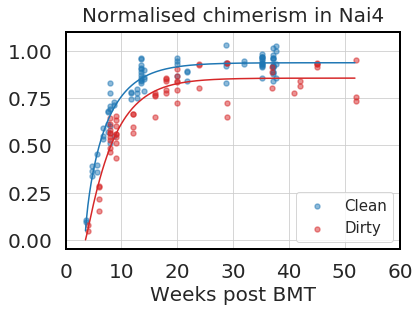

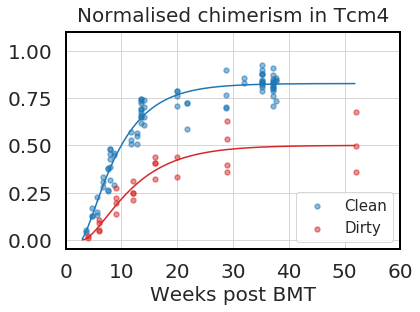

In [22]:
def GenlogModel(params, t):
    '''
    The general logistic function
    which is used to fit the spline in the chimerism data.
    '''
    t = np.array(t)
    A = params[0]
    B = params[1]
    r = params[2]
    c = params[3]
    expv = np.array(-1.*t*r)
    return 1/(A+B*np.exp(expv.astype(float)))**(1/c)


def CHIlogitResidualsFunc(rawParams, t, asinsqrtObs):
    '''
    The function calculates the residuals between predictions and the data
    for the source chimerism in asinsqrt scale.
    '''
    model = GenlogModel(rawParams, t)
    residuals = asinsqrtObs - asinsqrt(model, a =1.2)
    return residuals

def estimateSourceChimerism(data, sourcePop,paramsGuess):
    '''
    The function finds best fitting spline (define by sourceModelType) 
    in the source chimerism data for sourcePop population.    
    The funcion uses least_squares with methood trf='Trust Region Reflective'.
    Note that data = ChiNIMR or ChiUCL, where 
    ChiNIMR, ChiUCL = getSourceDataChim(sourcePop, dataAll)  
    and dataAll = import_data_source_cc_all(xls).
    '''
    asinsqrtCHI = data['asinsqrtNCHI'+sourcePop].values
    dpBMT = data['dpBMT'].values
    CHIresult = least_squares(CHIlogitResidualsFunc,paramsGuess,  loss='soft_l1', 
                              method='trf', args=(dpBMT, asinsqrtCHI))
    paramsHat = CHIresult['x']
    return paramsHat 

def estimateSourceCHIBoth(sourcePop,paramsGuess,verbose=False):
    '''
    The function finds best fitting splines (define by sourceModelTypeUCL and sourceModelTypeNIMR)
    for the source chimerism data in sourcePop population @ NIMR and UCL. 
    If verbose = True the plot with data and the splines are generated.
    '''
    data = import_data_source_chim_all(xls)
    dataNIMR, dataUCL = getSourceDataChim(sourcePop, data) 
    
    paramsHatNIMR = estimateSourceChimerism(dataNIMR,sourcePop,paramsGuess[0])
    paramsHatUCL = estimateSourceChimerism(dataUCL,sourcePop,paramsGuess[1])
 
    if verbose:
        mindpBMTAll = min(min(dataNIMR['dpBMT']), min(dataUCL['dpBMT']))
        maxdpBMTAll = max(max(dataNIMR['dpBMT']), max(dataUCL['dpBMT']))
        smoothdpBMT = np.arange(3*7, maxdpBMTAll,1)
        CHINIMRhatSmooth = GenlogModel(paramsHatNIMR, smoothdpBMT)
        CHIUCLhatSmooth = GenlogModel(paramsHatUCL, smoothdpBMT)
        
        fig, ax = plt.subplots()
        ax.grid(True, which = 'both')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
        ax.tick_params(labelsize = my_axis_fontsize, which = 'both', pad = 10)    
        ax.title.set_position([.5, 1.02]) 
        
        ax.scatter(dataUCL['dpBMT'], dataUCL['NCHI'+sourcePop],s=25, marker='o',
                   linewidth=1.4,alpha=0.5, color = palette[0],label = 'Clean')        
        ax.scatter(dataNIMR['dpBMT'], dataNIMR['NCHI'+sourcePop],s=25, marker='o',
                   linewidth=1.4,alpha=0.5, color = palette[3],label = 'Dirty')
                
        ax.plot(smoothdpBMT, CHINIMRhatSmooth, color=palette[3])
        ax.plot(smoothdpBMT, CHIUCLhatSmooth, color=palette[0])
     
        ax.tick_params(labelsize = my_axis_fontsize)
        ax.set_xticks([0,70, 140, 210, 280, 350, 420]) 
        ax.set_xticklabels([0,10,20,30,40,50,60])
        ax.legend( fontsize = 15, frameon = bool, loc = 4)
        ax.set_xlabel('Weeks post BMT', fontsize = my_lab_fontsize)
        ax.set_ylim(-0.05,1.1)  
        ax.set_title('Normalised chimerism in '+sourcePop, fontsize = 20)
        fig.savefig('NCHI'+sourcePop+'.pdf', format='pdf', bbox_inches='tight')

# Show splines for naive CD4 and central memory CD4 chimersim in Clean (UCL) and Dirty (NIMR) mice.
estimateSourceCHIBoth('Nai4',[(0.01, 1, 0.001, 2), (1, -1.2, 0.01, -0.5)], verbose = True)
estimateSourceCHIBoth('Tcm4',[(0.01, 1, 0.001, 2), (1, -1.2, 0.01, -0.5)], verbose = True)

# Introducing models which were considered to described observed data

In [23]:
'''
In this section we define functions to upload the data (cell counts & chimerism) 
from memory population (TCM and TEM) which later will be used for fitting different model.
Here we also define some general functions needed for fitting, as AIC, logLikelihood, etc.
'''
def get_source_pam(sourcePop, location):
    '''
    The function return parameters for best fitting spline 
    in sourcePop population ('Nai4' or 'Tcm4') @ location ('NIMR' or 'UCL') 
    which are saved in source_fits.xlsx file.
    '''    
    xls = pd.ExcelFile('source_fits.xlsx')
    df_source_cell_counts = xls.parse('cell counts')
    ind_loc = df_source_cell_counts['Location'] == location
    ind_pop = df_source_cell_counts['Population'] == sourcePop
    ind = ind_loc & ind_pop
    
    dfCC = df_source_cell_counts.copy()
    dfCC = dfCC.loc[ind, :]
    dfCC = dfCC.reset_index(drop=True)

    sourceCCPam = [dfCC['Smax'].values[0], dfCC['r'].values[0]]
    if sourcePop == 'Tcm4' and location == 'UCL':
        sourceCCPam = [dfCC['Smin'].values[0], dfCC['Smax'].values[0], dfCC['r'].values[0]]
        
    df_source_chimerism = xls.parse('chimerism')

    ind_loc = df_source_chimerism['Location'] == location
    ind_pop = df_source_chimerism['Population'] == sourcePop
    ind = ind_loc & ind_pop
    
    dfChi = df_source_chimerism.copy()
    dfChi = dfChi.loc[ind, :]
    dfChi = dfChi.reset_index(drop=True)
        
    sourceChiPam=[dfChi['A'].values[0],dfChi['B'].values[0], 
                  dfChi['r'].values[0], dfChi['c'].values[0]]

    return np.array(sourceCCPam), np.array(sourceChiPam)

def import_data_for_fits(xls): 
    '''
    The function creates the dataframe from master file
    with cell counts and normalised donor fraction (chimerism) of the target population 
    (central and effector memory CD4) from chimeric mice from both facilities, UCL and NIMR.
    '''
    dfchimeras = xls.parse('UCL & NIMR adult chimeras data')
    dfchimeras = dfchimeras[['Location and mouse type','Mouse age (days)',
                             'Mouse age @ BMT (days)','Days post BMT',
                             'Central memory CD4 cell counts',
                             'Effector memory CD4 cell counts',
                             'Normalised chimerism in central memory CD4',
                             'Normalised chimerism in effector memory CD4']]
    # Rename the columns for simplicity
    dfchimeras.rename(columns = {'Location and mouse type':'exptlocation',
                                 'Mouse age (days)':'age','Mouse age @ BMT (days)':'ageBMT',
                                 'Days post BMT':'dpBMT',
                                 'Central memory CD4 cell counts':'TotalTcm4',
                                 'Effector memory CD4 cell counts':'TotalTem4',
                                 'Normalised chimerism in effector memory CD4':'NCHITem4',
                                 'Normalised chimerism in central memory CD4':'NCHITcm4'},
                      inplace=True)

    # Add column with log of total counts and asinsqrt for chimerism.
    for col in ['NCHITem4','NCHITcm4']:
        dfchimeras['asinsqrt'+col] = asinsqrt((dfchimeras[col].values))
    for col in ['TotalTem4','TotalTcm4']:
        dfchimeras['log'+col] = np.log(dfchimeras[col].values)
    return(dfchimeras)


def getDataForFit(population, data):
    '''
    The function returns two dataframes for containing information about cell counts and 
    chimerism in the population of interest, central ('Tcm4') or effector ('Tem4') memory CD4,
    one for NIMR mice and the other for UCL mice.
    Note that data = import_data_for_fits(xls).
    '''
    NIMRindex = data['exptlocation'] == 'NIMR chimera'    
    UCLindex = data['exptlocation'] == 'UCL chimera'
   
    ddNIMR = data.copy()
    ddNIMR = ddNIMR.loc[NIMRindex, :]
    ddNIMR = ddNIMR.reset_index(drop=True)
    
    ddUCL = data.copy()
    ddUCL = ddUCL.loc[UCLindex, :]
    ddUCL = ddUCL.reset_index(drop=True)
    
    cols_of_interest = ['age','ageBMT','dpBMT','Total'+population,'logTotal'+population,
                        'NCHI'+population, 'asinsqrtNCHI'+population]
    
    popIndex = np.logical_not(np.isnan(ddNIMR['NCHI'+population]))  
    datNIMR = ddNIMR.copy()
    datNIMR = datNIMR.loc[popIndex, :]
    datNIMR = datNIMR.reset_index(drop=True) 
    datNIMR = datNIMR[cols_of_interest]

    popIndex = np.logical_not(np.isnan(ddUCL['NCHI'+population]))  
    datUCL = ddUCL.copy()
    datUCL = datUCL.loc[popIndex, :]
    datUCL = datUCL.reset_index(drop=True) 
    datUCL = datUCL[cols_of_interest]
    return datNIMR, datUCL

In [24]:
'''
The table contains all data used for fitting the target population (central or effector memory)
to cell counts and normalised donor fraction (chimersim) simultaneusly.
'''
#import_data_for_fits(xls)

'\nThe table contains all data used for fitting the target population (central or effector memory)\nto cell counts and normalised donor fraction (chimersim) simultaneusly.\n'

# The  homogeneous model
Our simplest description of the kinetics of the generation and renewal of  CD4 T$_\text{CM}$ and T$_\text{EM}$ is illustrated in Fig.2A in the paper and was formulated as follows. We assume that cells flow into a memory subset of total size $M(t)$ from a precursor population $S(t)$  at total rate $\varphi S(t)$, where $t$ is the age of the animal. The rate constant $\varphi$ is the force of recruitment, a compound parameter which is the product of the \textit{per capita} rate of recruitment of cells from the source population per day multiplied by number representing any net expansion that occurs during recruitment. Memory is also lost at net \textit{per capita} rate $\lambda$. This rate is the balance of loss through death and/or differentiation, and any compensatory cell production through division, and represents the rate of decline of (at least partly) self-renewing populations, rather than the loss rate of individual cells.  We place no constraints on these rates, and so $\lambda$ may be positive or negative.<br>
$$
\dfrac{dM(t)}{dt} = \varphi S(t) - \lambda M(t). \ \ \ \ \ \ \ \ \ (1)\\
$$
We assume host and donor cells each obey the same kinetics, so that <br> <br>
$$
\begin{array}{c c c}
\dfrac{dM_\text{host}(t)}{dt} &=& \varphi S_\text{host}(t) - \lambda M_\text{host}(t) \ \ \ \ \ \ \ \ \ (2)\\
\dfrac{dM_\text{donor}(t)}{dt} &=& \varphi S_\text{donor}(t) - \lambda M_\text{donor}(t), \ \ \ \ \ \ \ \ \ (3)
\end{array}
$$ <br>
where the total population size $M(t) = M_{\text{donor}}(t)+M_\text{host}(t)$. Our strategy for parameter estimation was to fit this model simultaneously to the timecourses of total numbers of memory cells $M(t)$, and the donor chimerism within memory, $\chi_\text{M}(t)$, which is the fraction of cells in memory that are donor-derived.  For reasons described below, we normalise this fraction to the proportion of early double-positive (DP1) thymocytes that are donor-derived, which is measured in the same mouse and denoted $\chi_\text{DP1}$;<br>
$$
\chi_\text{DP1}  = \dfrac{\text{DP1}_\text{donor}}{\text{DP1}_\text{host+donor}}, \ \ \ 
\chi_M(t)  = \dfrac{M_\text{donor}(t)}{M(t)}, \ \ \ 
\chi_\text{M, norm}(t)  = \dfrac{\chi_M(t)}{ \chi_\text{DP1}}.\\
$$ <br>
Eqns.(2) and (3) then give <br>
$$
\dfrac{d}{dt}\chi_\text{M, norm}(t)   =   \dfrac{d}{dt} \left( \dfrac{M_\text{donor}(t)}{\chi_\text{DP1}(t) M(t)} \right )
 =  \dfrac{1}{\chi_\text{DP1}(t) } \dfrac{d}{dt} \left( \dfrac{M_\text{donor}(t)}{M(t)} \right ) - \dfrac{d\chi_\text{DP1}/dt}{\chi_\text{DP1}(t)^{2}}\left( \dfrac{M_\text{donor}(t)}{M(t)} \right ).
$$ <br>
If observations are made sufficiently long after BMT (more than approximately 4 weeks), chimerism among DP thymocytes can be assumed to have stabilised (Hogan _et al._ 2015) and so we can neglect the term in $d\chi_\text{DP1}/dt$. Then <br> <br>
$$\begin{align*}
\dfrac{d}{dt}\chi_\text{M, norm}(t) & = \dfrac{1}{\chi_\text{DP1} M(t)} \left( \varphi S_\text{donor}(t) - \lambda M_\text{donor}(t) - \dfrac{M_\text{donor}(t)}{M(t)} \dfrac{dM(t)}{dt}  \right ) \nonumber\\
& = \dfrac{1}{\chi_\text{DP1} M(t)} \left( \varphi S_\text{donor}(t) - \lambda M_\text{donor}(t) - \chi_{M}(t)  \left( \varphi S(t)  - \lambda M(t) \right)  \right) \nonumber\\
& = \dfrac{1}{\chi_\text{DP1} M(t)} \left( \varphi S_\text{donor}(t) - \chi_{M}(t)  \varphi S(t)  \right) \nonumber\\
& = \dfrac{\varphi S(t) }{M(t)} \left( \chi_\text{source, norm}(t)   -\chi_\text{M, norm}(t) \right),\ \ \ \ \ \ \ \ \ (4)
%\label{eqn:chi1}
\end{align*}$$ <br>
where we  define <br>
$$
\chi_\text{source, norm}(t) = \dfrac{1}{\chi_\text{DP1}} \dfrac{S_\text{donor}(t)}{S(t)}.
$$ <br>
By normalising the chimerism of both the source and the memory populations to that in the thymus, we remove any variation in these quantities due to variation across individuals in the degree of chimerism achieved with busulfan treatment and BMT.

Fitting required initial conditions for the total numbers of memory cells and donor chimerism. We solved all of the models from host age $t_{0}$, which was chosen to be the time at which donor chimerism in memory for the mouse with the youngest age at BMT could be assumed to be zero and donor chimerism in DP1 had stabilised. This was host age 66d for the clean mice and 84 days for dirty mice (26d and 28d post-BMT respectively). Our results were insensitive to changes of a few days in these baseline ages. We also required functional forms for the kinetics of the source population $S(t)$ and $\chi_\text{source, norm}(t)$. 

When considering T$_\text{CM}$ as a source for T$_\text{EM}$ we described $S(t)$ with either a sigmoid or exponential decay curve, as shown above. 

The homogeneous model is characterised by the three unknowns $M(t_0)$, $\lambda$ and $\varphi$.  To estimate them for a given subset, location and source population  we solved eqns.(1) and (4) numerically and fitted them  simultaneously to the timecourses of total numbers and normalised chimerism of the memory subset.
The clean mice underwent BMT at a range of ages, which were accounted for individually in the fitting; model predictions for a mouse which underwent BMT at age $t_{B}$ and was observed at age $t$ were generated by running the model from host age $T = t_{b}+$ 26d (clean) or $ t_{b}+$ 28d (dirty) to time $t$; with $M(T)$ calculated from $M(t_{0})$ using eqn.(1),  and  the normalised chimerism at time $T$ assumed to be zero.
  To estimate parameters we used the reduced likelihood approach described in (Hogan _et al._ 2015).  Memory cell numbers were log-transformed and chimerism values were arcsine-square-root transformed to normalise the distributions of residuals. 

In [63]:
'''
In this section we define the homogeneous model. 
Every function defined here having suffix HM refers to the homogeneous model.
'''

def DerivativesNoCHI_HM(y, Time, params, givens, sourceModelType):
    '''
    Define Eq.(1) which solves only for total cell counts.
    '''
    T_t = y 
    SourceTparams, SourceCHIparams = givens
    T_0, phi, lam= params 
    SourceT_t = sourceModelType(SourceTparams, Time)
    dT_dt = phi * SourceT_t - lam * T_t
    return dT_dt


def DerivativesCHI_HM(y, dpBMTTime, params, givens, sourceModelType):
    '''
    The function defines Eq. (1) and (4), which solves for total cell counts and chimerism.
    Here we consider mouse having BMT @ ageBMT_ and where cells were counted
    dpBMTTime days after BMT (i.e. at age_ = ageBMT_+dpBMTTime).
    '''
    T_t, CHI_t = y 
    SourceTparams, SourceCHIparams = givens
    phi, lam, ageBMT_ = params
    # Define age of mouse given dpBMT and ageBMT
    age_ = ageBMT_ + dpBMTTime
    # Find source cell counts @ age_
    SourceT_t = sourceModelType(SourceTparams, age_)   
    # Find value of source chimerism @ dpBMTTime
    SourceCHI_t = GenlogModel(SourceCHIparams, dpBMTTime)
    # Solve equations given SourceT_t @ age_ and SourceCHI_t @ dpBMTTime.
    dT_dt = phi * SourceT_t - lam * T_t 
    dCHI_dt = phi * (SourceT_t / T_t) * (SourceCHI_t - CHI_t) 
    derArray = np.array([dT_dt, dCHI_dt])
    return derArray

def RawParamsToTrans_HM(rawParams):
    '''
    The function transforms parameters to make sure that 
    during fitting T_0 (total cell counts @ t_0) and phi (influx from the source) >0.  
    Here we allow lam (net loss rate) to be free parameter (positive or negative).
    '''
    T_0, phi, lam= rawParams
    exprT_0 = np.log(T_0)
    logphi = np.log(phi)
    exprlam = lam
    transParams = [exprT_0, logphi, exprlam]
    return transParams

def TransParamsToRaw_HM(transParams):
    '''
    The function transforms back the parameters to its raw version.
    '''
    exprT_0,  logphi, exprlam = transParams
    T_0 =   np.exp(exprT_0)
    phi =  np.exp(logphi)
    lam = exprlam
    rawParams = [T_0,  phi, lam]
    return rawParams

def makeResPredCurves_HM(sourceModelType, target, targetParams, sourceParams, data):
    '''
    The function makes prediction of the solution of Eqs (1) and (4)
    and computes the residuals between the prediction and the data
    in log scale for cell counts and in arcsinsqrt scale for chimerism.
    '''   
    # Here we create dictionary of chimerism value given age, age @ BMT 
    # and days post BMT, respectively.
    CHIDictage = {}
    CHIDictageBMT = {}
    CHIDictdpBMT = {}
    
    # Find max/min values for age, age @ BMT and days post BMT whichare needed later to
    # define the time.
    maxage = np.max(data['age'])
    minageBMT = np.min(data['ageBMT'])
    mindpBMT = np.min(data['dpBMT'])
    maxdpBMT = np.max(data['dpBMT']) 
    
    # Here we define range of ages we want to solve eqs (1) and (4) for.
    # We want to start @ age = min of all observed age @ BMT + min of observed days post BMT
    # to make sure all data can be find in our prediction curve.
    AgeLong = np.arange(minageBMT+mindpBMT, maxage+1, 1)
 
    SourceTparams, SourceCHIparams = sourceParams
    Givens = [SourceTparams, SourceCHIparams]
    T_0, phi, lam = targetParams
    
    # Here we solve for cell counts only (using function DerivativesNoCHI_HM) 
    # for age range AgeLong.
    T_t_no_CHI = odeint(DerivativesNoCHI_HM, T_0,AgeLong,
                        args=(targetParams, Givens, sourceModelType))

    # Defne variables holding residuals for cell counts, chimerism.
    resi_cc = []
    resi_chi = []

    # First we define the time range for chimerism from mindpBMT
    # We assume that chimerism CHI_0 = 0 @ mindpBMT days post BMT 
    # (whenever BMT was performed).
    # Hence we want to solve for chimerism starting @ mindpBMT.
    CHI_Time = np.arange(mindpBMT, maxdpBMT+1,1)    
    
    # Here we are going through all ages @ BMT observed within data 
    # to predict chimerism given our parameters.
    # np.unique(data['ageBMT'].values) gives list of unique values 
    # of age @ BMT observed in the data.
    for ageBMT_ in np.unique(data['ageBMT'].values):
        # age @ BMT is variable hence we need to vary this value solving for chimerism.
        ageBMTparams = [phi, lam, ageBMT_ ]    

        # We need to find the total cell counts @ age0_ given ageBMT_ and mindpBMT 
        # from T_t_no_CHI computed @ AgeLong range.
        age0_ =ageBMT_+mindpBMT
        T_0ageBMT = T_t_no_CHI[AgeLong == age0_][0]      
            
        # We solve for chimerism starting @ mindpBMT, where CHI_0 = 0.
        OdeSys = odeint(DerivativesCHI_HM,[T_0ageBMT, 0.], CHI_Time, 
                        args=(ageBMTparams, Givens, sourceModelType))
        MT = OdeSys.T[0]
        CHIT = OdeSys.T[1] 

        # Given ageBMT_ the measurments were taken at different times post BMT (dpBMT_).
        # Here we go through all observed dpBMT_ values to take the predicted chimerism
        # and compare with the observations.            

        # ageBMTindex is the index in the data refering to rows 
        # with data observed for mice having BMT @ ageBMT_
        ageBMTindex = data['ageBMT'].values == ageBMT_        
        
        # dpBMTindex is the counter within ageBMTindex
        # reffering to one row with data observed for mice having BMT @ ageBMT_
        # for specific dpBMT_ 
        dpBMTindex = 0
        
        for dpBMT_ in data['dpBMT'].values[ageBMTindex]:     
            # To compute the residuals first we find index in time range
            # CHI_Time, where derivatives were solved, such that CHI_Time =  dpBMT_.
            ind_dpBMT_ = np.where(CHI_Time == dpBMT_)[0][0]
            
            # We find the prediction for cell counts @ dpBMT_.
            predict = MT[ind_dpBMT_]
            # We find the value of observed data @ ageBMT_ (index = ageBMTindex)
            # for counter dpBMTindex referring to data @ dpBMT_.
            dd = data['logTotal'+target].values[ageBMTindex][dpBMTindex]
            # We calculate the residuals and we save them and its time points.
            resi_cc.append(dd - np.log(predict))
            
            # .. and the same for the chimerism
            Chipredict = CHIT[ind_dpBMT_]
            dd = data['asinsqrtNCHI'+target].values[ageBMTindex][dpBMTindex]
            resi_chi.append(dd-asinsqrt(Chipredict))
            
            # We save the predicted curves given age_, ageBMT_, dpBMT_ (for plotting later).
            CHIDictage.update({ageBMT_+dpBMT_: CHIT})
            CHIDictageBMT.update({ageBMT_: CHIT})
            CHIDictdpBMT.update({dpBMT_: CHIT})  
            
            # Increase dpBMT index as we go through dpBMT_ range within ageBMT_.
            dpBMTindex = dpBMTindex + 1
            
    # Save all residuals as an array objects 
    resi_cc = np.array(resi_cc)
    resi_chi = np.array(resi_chi)
    CHIDict = [CHIDictage, CHIDictageBMT, CHIDictdpBMT]
    # Return the residuals and the dictionary with chimerism curves.
    return resi_cc, resi_chi, CHIDict

# The two-phase model
The two-phase model (see Fig.2B in the paper) describes the kinetics of CD4 T$_\text{CM}$ and T$_\text{EM}$ assuming that both comprise two subpopulations with distinct rates of loss, <br>
$$
    M(t) = M_\text{fast}(t) + M_\text{slow}(t), \ \ \ \ \ (1)%\label{eq: M_tot TC model}
$$ <br>
where $t$ is the mouse age. We assume that cells flow only into one subset from the precursor population $S(t)$ at total rate $\varphi S(t)$, and transition to the next compartment at rate $\gamma$; <br>
$$
\begin{array}{ccc}
\dfrac{dM_\text{fast}(t)}{dt} & = & \varphi S(t) - \gamma M_\text{fast}(t) -\lambda_\text{fast} M_\text{fast}(t) \ \ \ \ \ (2) \\
\dfrac{dM_\text{slow}(t)}{dt} & = & \gamma M_\text{fast}(t) -\lambda_\text{slow} M_\text{slow}(t). \ \ \ \ \ (3)
\end{array}
%\label{eq:M_fastslow_ODE}
$$<br>
Note that despite the nomenclature,  when estimating the rates of loss of these subsets, we did not constrain them; rather, the model fits indicated that the upstream population has the greater net rate of loss. 
 
Assuming that host and donor cells obey the same kinetics, so that  eqns.(2) and (3) hold identically for both populations, then similar to the derivation of the equation for chimerism in the homogeneous model, we obtain the following equations for the dynamics of donor chimerism in the fast and slow subsets, each normalised to the chimerism of DP1 thymocytes;<br> <br>
$$
\begin{array}{ccc}
\dfrac{d}{dt}\chi_\text{fast, norm}(t) & =  &\dfrac{\varphi S(t)}{M_\text{fast}(t)} (\chi_\text{source, norm}(t)-\chi_\text{fast, norm}(t))\\
\dfrac{d}{dt}\chi_\text{slow, norm}(t) & =  & \dfrac{\gamma M_\text{fast}(t)}{M_\text{slow}(t)}(\chi_\text{fast, norm}(t) - \chi_\text{slow, norm}(t)),
\end{array}
\label{eq:chiODEs}
$$<br>
where <br>
$$
\chi_\text{fast, norm}(t)  =  \dfrac{1}{\chi_\text{DP1}} \dfrac{M_\text{fast}^\text{donor}(t)}{M_\text{fast}(t)}, \;\;\; 
\chi_\text{slow, norm}(t)  =  \dfrac{1}{\chi_\text{DP1}} \dfrac{M_\text{slow}^\text{donor}(t)}{M_\text{slow}(t)}. 
%\label{eq: chi fast, slow}
$$ <br>
The normalised chimerism in the fast and slow populations combined is <br> <br>
$$
\chi_\text{M, norm}(t) = \chi_\text{fast, norm}(t)\dfrac{M_\text{fast}(t)}{M(t)} + \chi_\text{slow, norm}(t) \dfrac{M_\text{slow}(t)}{M(t)}.\ \ \ \ \ (4)
%\label{eq: chi_tot TC model}
$$<br>
We dealt with different ages at BMT using the same approach as described for the simplest model.  We determined the initial sizes of the subsets $M_\text{fast}(t_0)$ and $M_\text{slow}(t_0)$ by assuming that fast cells were close to  steady state being in quasi-equilibrium with either source, which are changing slowly (Fig.1B in the paper), and allowing $M_\text{slow}(t_0)$ to be free. Allowing both population sizes to be free yielded very similar results at the cost of an additional parameter. The numbers of host-derived cells in the fast and slow memory subsets at each time $T$ were then generated from $M_\text{fast}(t_0)$ and $M_\text{slow}(t_0)$ by running the model forward in time from age $t_{0}$ using eqns.(2) and (3).  The two-phase model is then characterised by five unknowns; $M_\text{slow}(t_0)$, the loss rates $\lambda_\text{fast}$ and $\lambda_\text{slow}$, the transition rate $\gamma$, and the force of recruitment $\varphi$. To estimate these parameters we fitted the solutions of eqns.(1), (2), (3)  and (4) simultaneously to the timecourses of total memory cell numbers $M(t)$ and the normalised chimerism $\chi_\text{M, norm}(t)$, using the empirical forms of $S(t)$ and $\chi_\text{source, norm}(\tau)$ where $t$ is host age and  $\tau$ is time post-BMT. 

In [64]:
'''
In this section we define the two-phase model. 
Every function defined here having suffix TP refers to the two-phase model.
'''

def DerivativesNoCHI_TP(y, Time, params, givens, sourceModelType):
    '''
    Define Eqs.(2) which solves only for total cell counts 
    in fast and slow population respectively.
    '''
    Mf_t, Ms_t = y 
    SourceTparams, SourceCHIparams = givens
    Mf0, Ms0, phi, gamma, lamF, lamS = params 
    SourceM_t = sourceModelType(SourceTparams, Time)
    dMf_t = phi*SourceM_t - lamF*Mf_t-gamma*Mf_t
    dMs_t = gamma*Mf_t - lamS*Ms_t
    return np.array([dMf_t, dMs_t])

def DerivativesCHI_TP(y, dpBMTTime, params, givens, sourceModelType):
    '''
    The function defines Eqs. (2), (3) and (4), which solves for total cell counts
    and chimerism in fast and slow population respectively.
    Here we consider mouse having BMT @ ageBMT_ and where cells were counted
    dpBMTTime days after BMT (i.e. at age_ = ageBMT_+dpBMTTime).
    '''
    Mf_t, Ms_t, chiMf_t, chiMs_t = y 
    SourceTparams, SourceCHIparams, ageBMT_ = givens
    Mf0, Ms0, phi, gamma, lamF, lamS = params  
    # Define age of mouse given dpBMT and ageBMT.
    age_ = ageBMT_ + dpBMTTime
    # Find source cell counts @ age_.
    SourceM_t = sourceModelType(SourceTparams, age_)   
    # Find value of source chimerism @ dpBMTTime.
    chiS_t = GenlogModel(SourceCHIparams, dpBMTTime)
    # Solve equations given SourceM_t @ age_ and chiS_t @ dpBMTTime.
    dMf_t = phi*SourceM_t - lamF*Mf_t-gamma*Mf_t
    dMs_t = gamma*Mf_t - lamS*Ms_t   
    dchiMf_t = (phi*SourceM_t/Mf_t)*(chiS_t-chiMf_t)
    dchiMs_t = Mf_t*gamma*(chiMf_t-chiMs_t)/Ms_t
    derArray = np.array([dMf_t, dMs_t,  dchiMf_t, dchiMs_t])
    return derArray

def RawParamsToTrans_TP(rawParams):
    '''
    The function transforms parameters to make sure that 
    during fitting Ms0 (total cell counts @ t_0 in slow population), phi (influx from the source),
    gamma (influx from fast to slow) > 0.  
    Here we allow lamF and lamS (net loss rates) to be free parameters (positive or negative).
    '''
    Ms0, phi, gamma, lamF, lamS = rawParams   
    exprMs0 = np.log(Ms0)
    exprphi = np.log(phi) 
    exprgamma = np.log(gamma)
    transParams = [exprMs0, exprphi, exprgamma, lamF, lamS]
    return transParams

def TransParamsToRaw_TP(transParams):
    '''
    The function transforms back the parameters to its raw version.
    '''
    exprMs0, exprphi, exprgamma, lamF, lamS = transParams
    Ms0 = np.exp(exprMs0)
    phi = np.exp(exprphi)
    gamma = np.exp(exprgamma)
    rawParams = [Ms0, phi, gamma, lamF, lamS]
    return rawParams

def makeResPredCurves_TP(sourceModelType, target, targetParams, sourceParams, data):
    '''
    The function makes prediction of the solution of Eqs (2) and (4)
    and computes the residuals between the prediction and the data
    in log scale for cell counts and in arcsinsqrt scale for chimerism.
    '''  
    # Here we create dictionary of chimerism value given age, age @ BMT 
    # and days post BMT, respectively.
    CHIDictage = {}
    CHIDictageBMT = {}
    CHIDictdpBMT = {}
        
    # Find max/min values for age, age @ BMT and days post BMT whichare needed later to
    # define the time.
    maxage = np.max(data['age'])
    minageBMT = np.min(data['ageBMT'])   
    mindpBMT = np.min(data['dpBMT'])
    maxdpBMT = np.max(data['dpBMT'])

    # Here we define range of ages we want to solve eqs (2) and (3) for.
    # We want to start @ age = min of all observed age @ BMT + min of observed days post BMT
    # to make sure all data can be find in our prediction curve.    
    AgeLong = np.arange(minageBMT+mindpBMT, maxage+1, 1)

    SourceTparams, SourceCHIparams = sourceParams
    Givens = [SourceTparams, SourceCHIparams]
    Ms0, phi, gamma, lamF, lamS   = targetParams
    
    # We assume that fast cells are close to steady state being in quasi-equilibrium. 
    # Hence its initial value is found from the following equation.
    Mf0 = phi*sourceModelType(SourceTparams,minageBMT+mindpBMT)/(lamF+gamma)
    
    Params = [Mf0, Ms0, phi, gamma, lamF, lamS]
    
    # Here we solve for cell counts only (using function DerivativesNoCHI_TP) 
    # for age range AgeLong. 
    Mt_no_CHI = odeint(DerivativesNoCHI_TP, [Mf0, Ms0],AgeLong,
                       args=(Params, Givens, sourceModelType))    
    Mft_no_CHI = Mt_no_CHI.T[0]
    Mst_no_CHI = Mt_no_CHI.T[1]
    
    # Defne variables holding residuals for cell counts, chimerism.
    resi_cc = []
    resi_chi = []
    
    # Here we are going through all ages @ BMT observed within data 
    # to predict chimerism given our parameters.
    # np.unique(data['ageBMT'].values) gives list of unique values 
    # of age @ BMT observed in the data.
    CHI_Time = np.arange(mindpBMT, maxdpBMT+1,1)
    
    # Here we are going through all ages @ BMT observed within data 
    # to predict chimerism given our parameters.
    # np.unique(data['ageBMT'].values) gives list of unique values of 
    # age @ BMT observed in the data.
    for ageBMT_ in np.unique(data['ageBMT'].values):
        # age @ BMT is variable hence we need to vary this value solving for chimerism.
        GivensAgeBMT = [SourceTparams, SourceCHIparams, ageBMT_]            
        
        # We need to find the total cell counts @ age0_ given ageBMT_ and mindpBMT 
        # from Mft_no_CHI and Mst_no_CHI computed @ AgeLong range.
        age0_ =ageBMT_+mindpBMT
        Mf0ageBMT = Mft_no_CHI[AgeLong == age0_][0]
        Ms0ageBMT = Mst_no_CHI[AgeLong == age0_][0]
        
        # We solve for chimerism starting @ mindpBMT, where CHI_0 = 0 
        # within fast and slow population.
        ageBMTparams = [Mf0ageBMT,Ms0ageBMT, phi, gamma, lamF, lamS]
        OdeSys =odeint(DerivativesCHI_TP,[Mf0ageBMT,Ms0ageBMT,0.,0.],CHI_Time, 
                       args = (ageBMTparams, GivensAgeBMT, sourceModelType))
        
        Mf_t = OdeSys.T[0]
        Ms_t = OdeSys.T[1]
        chiMf_t = OdeSys.T[2]
        chiMs_t = OdeSys.T[3]
        
        # We find the total cell counts and the combined chimerism using eqs. (1) and (4). 
        MT = Mf_t + Ms_t
        CHIT = chiMf_t*Mf_t/MT + chiMs_t*Ms_t/MT
        
        # Given ageBMT_ the measurments were taken at different times post BMT (dpBMT_).
        # Here we go through all observed dpBMT_ values to take the predicted chimerism
        # and compare with the observations.            

        # ageBMTindex is the index in the data refering to rows 
        # with data observed for mice having BMT @ ageBMT_
        ageBMTindex = data['ageBMT'].values == ageBMT_        
        
        # dpBMTindex is the counter within ageBMTindex
        # reffering to one row with data observed for mice having BMT @ ageBMT_
        # for specific dpBMT_ 
        dpBMTindex = 0
        
        for dpBMT_ in data['dpBMT'].values[ageBMTindex]:
            # To compute the residuals first we find index in time range
            # CHI_Time, where derivatives were solved, such that CHI_Time =  dpBMT_.
            ind_dpBMT_ = np.where(CHI_Time==dpBMT_)[0][0]
            
            # We find the prediction for cell counts @ dpBMT_.
            predict = MT[ind_dpBMT_]
            # We find the value of observed data @ ageBMT_ (index = ageBMTindex)
            # for counter dpBMTindex referring to data @ dpBMT_.
            dd = data['logTotal'+target].values[ageBMTindex][dpBMTindex]
            # We calculate the residuals and we save them and its time points.
            resi_cc.append(dd - np.log(predict))
            
            # .. and the same for the chimerism
            Chipredict = CHIT[ind_dpBMT_]
            dd = data['asinsqrtNCHI'+target].values[ageBMTindex][dpBMTindex]
            resi_chi.append(dd-asinsqrt(Chipredict))
            
            # We save the predicted curves given age_, ageBMT_, dpBMT_ (for plotting later).
            CHIDictage.update({ageBMT_+dpBMT_: CHIT})
            CHIDictageBMT.update({ageBMT_: CHIT})
            CHIDictdpBMT.update({dpBMT_: CHIT})  
            
            # Increase dpBMT index as we go through dpBMT_ range within ageBMT_.
            dpBMTindex = dpBMTindex + 1

    # Save all residuals as an array objects 
    resi_cc = np.array(resi_cc)
    resi_chi = np.array(resi_chi)
    CHIDict = [CHIDictage, CHIDictageBMT, CHIDictdpBMT]
    # Return the residuals and the dictionary with chimerism curves.
    return resi_cc, resi_chi, CHIDict

# The age-dependent loss model
In this model (Fig.2C in the paper)  the loss rate $\lambda$  is a function of the time since entry of a cell or its ancestor into memory, which we denote its age $a$. The time evolution of the population density of memory cells of age $a$ at host age $t$ is given by <br> <br>
$$
\frac{\partial M (t, a)}{\partial t} + \frac{\partial M (t, a)}{\partial a} = - \lambda(a) M(t, a),
$$ <br>
where the population density of cells of age zero is the rate at which cells flow into memory from the source,<br><br>
$$
M(t, a=0) = \varphi S(t),
$$<br>
and we must specify the overall population density with respect to cell age $M(t_0,a) = g(a)$ at some initial mouse age, $t_0$. As described above, we assumed all cells present at $t_{0}$ are host-derived, and we model their age distribution as $ g(a) = \varphi S(t_0) \, e^{p a} $. The free parameter $p$ could be positive or negative, such that older cells can initially be over- or under-represented compared to younger cells. This definition  ensures $g(0)$ is the rate of influx of cells of age zero from the source at time $t_0$, $\varphi S(t_0)$.  We explored exponential ($\lambda(a) = \lambda_0 \, e^{-a/A}$) and sigmoid ($\lambda(a) = \lambda_0/(1+ (a/A)^{n})$) forms for the dependence of the net loss rate $\lambda$ on cell age, with $n$ = 1, 2, 3, 5 and 10.  We found that $n=3$ consistently yielded the best fits, with the exponential  performing the most poorly. 

Solving this system using the method of characteristics allows us to track the fates of three cell populations:   the host-derived population that was present at $t_{0}$, $M_\text{host}^\text{init} (t,a)$, host-derived cells that entered the population after $t_{0}$ $M_\text{host}^\text{new} (t,a)$, and the donor population $M_\text{donor} (t,a)$, all of which entered memory after $t_{0}$. Total memory cell numbers at $t \ge t_{0}$ are then <br>
$$
M_\text{total}(t) = \int_{a=0}^t \left ( M_\text{host}^\text{init} (t,a) + M_\text{host}^\text{new} (t,a)+ M_\text{donor} (t,a) \right ) \, da. 
$$<br>
The terms in this expression evolve according to<br> <br>
$$\begin{equation*}
\begin{aligned} 
	M_\text{host}^\text{init}(t,a) &= g(a-(t-t_0)) \exp \bigg( - \int_{a-(t-t_0)}^a \lambda(s) \, ds \bigg), \,  \, t-t_0 \le a \le t \\ 
	M_\text{host}^\text{new}(t,a) &= \varphi S_\text{host}(t-a) \exp \bigg (- \int_0^a \lambda(s) \, ds \bigg), \,   \, 0 \le a \le t-t_0\\
	M_\text{donor}(t,a) &=  \varphi S_\text{donor}(t-a) \exp \bigg (- \int_0^a \lambda(s) \, ds \bigg),  \,   \, 0 \le a \le t-t_0.
\end{aligned} 
%\label{fig:PDEsolution2}
\end{equation*}$$<br>
where $S_\text{host}(t) = (1-\chi_\text{source}(t)) S(t)$ and $S_\text{donor}(t) = \chi_\text{source}(t) S(t)$. This gives<br> <br>
$$
M_\text{total}(t) = \int_{a=t-t_0}^t g(a-(t-t_0)) \exp \bigg( - \int_{a-(t-t_0)}^a \lambda(s) \, ds \bigg) da + \varphi \int_{a=0}^{t-t_0} S(t-a) \exp \bigg (- \int_0^a \lambda(s) \, ds \bigg) da. \ \ \ \ \ (1)
%\label{eqn:ASM-Mtotal}
$$<br>
The normalised donor chimerism is<br>
$$\begin{equation*}
\begin{aligned} 
\chi_\text{M, norm}(t)= \frac{M_\text{donor}(t)} {\chi_\text{DP1} \, M_\text{total}(t)} & =  \frac{\int_{a=0}^{t-t_{0}} M_\text{donor}(t,a)\, da} {\chi_\text{DP1} \, M_\text{total}(t)}
  =   \frac{ \varphi }{M_\text{total}(t)}   \int_{a=0}^{t-t_{0}}  \chi_\text{source, norm}(t -a ) S(t-a) \exp \bigg (- \int_0^a \lambda(s)  \, ds \bigg ) da.\ \ \ \ \ (2)
\end{aligned} 
%\label{eqn:ASM-chinorm}
\end{equation*}$$<br>
We fit eqns.(1) and (2) to the timecourses of their observed counterparts from host age $t_0$ onwards. This model has four free parameters; $p$ and $\varphi$, which, together with the observed value of $S(t_0)$, specify the initial age distribution of host cells, $g(a) = \varphi S(t_0) e^{pa}$ ; and $\lambda_0$ and $A$, which specify the form of $\lambda(a)$. The parameters $p$ and $\varphi$ then determine the initial number of host-derived memory cells; <br><br>
$$
M_\text{total}(t_0) \equiv \int_0^{t_0} g(a) da = \varphi S(t_0) (e^{p t_0} - 1)/p.
$$<br>
As described above, this model can be fitted simultaneously to data from mice who underwent BMT at different ages, replacing $t_{0}$ in eqn.(2) with the age at BMT plus 26d or 28d for clean and dirty mice respectively.

In [65]:
'''
In this section we define the age-dependent loss model. 
Every function defined here having suffix ADL refers to the age-dependent loss model.
'''

def fun_g(a, param):
    '''
    The function defines g(a).
    '''
    p, phi, ST_0 = param
    return phi*ST_0*np.exp(p*a)    
        
def fun_lam(a, param):
    '''
    The function defines lambda(a) for n = 3.
    '''
    lam0, A = param
    return lam0/(1.+(a/A)**(3))

def integral_fun(fun, a,b, param):
    '''
    The function integrates function fun from a to b
    using module quad from scipy.integrate library. 
    '''
    res, err = quad(fun, a, b, args=(param))
    return res
    
def Minit(a,t, param):
    '''
    The function returns the number of cells in host before BMT
    at time t for cells which left source a days ago.
    This function is defined for t >= a >= t-t0.
    Note that Minit(a,t,param) = Minit^host(t,a), where Minit^host(t,a) is defined above.
    '''
    ST_0, phi, p, t0, lam0, A = param
    param_g = [p, phi, ST_0]
    param_lam = [lam0, A]
    return fun_g(a-t+t0, param_g)*np.exp(-integral_fun(fun_lam, a-t+t0,a, param_lam))
    
def Mtheta(a,t,param, sourceModelType):
    '''
    The function returns the number of cells (donor+host) after BMT
    at time t for cells which left source a days ago.
    This function is defined for t >= a >= 0.
    Note that Mtheta(a,t, param) = Mnew^host(t,a)+M^donor(t,a),
    where Mnew^host(t,a) and M^donor(t,a) are defined above. 
    '''
    lam0, A , phi, source_pams= param
    param_lam = [lam0, A]
    return phi*sourceModelType(source_pams, t-a)*np.exp(-integral_fun(fun_lam, 0, a, param_lam))

def Mtotal(t,param, sourceModelType):
    '''
    The function returns total cell counts at age t and it follows eqn.(1).
    '''
    p, t0, lam0, A , phi, ST_0, source_pams  = param
    param_Minit = [ST_0, phi, p, t0, lam0, A]
    param_Mtheta = [lam0, A , phi, source_pams]
    int1 = integral_fun(Minit, t-t0,t, (t, param_Minit))
    int2 = integral_fun(Mtheta,0,t-t0, (t, param_Mtheta, sourceModelType))
    return int1+int2
    
def MthetaDonor(a, t,param, sourceModelType):
    '''
    The function returns the number of cells in donor population after BMT
    at time t for cells which left the source a days ago.
    This function is defined for t >= a >= 0.
    Note that MthetaDonor(a,t,param,sourceModelType) = M^donor(t,a), 
    where M^donor(t,a) is defined above.
    '''
    lam0, A , phi, ageBMT, source_pams, chi_source_pams= param
    # We can find the cell counts in the source donor population 
    # multiplying the total cell counts in the source by the chimerism in the source.
    Sdonor = GenlogModel(chi_source_pams, t-a)*sourceModelType(source_pams, t-a)
    param_lam = [lam0,A]
    return phi*Sdonor*np.exp(-integral_fun(fun_lam, 0, a, param_lam))
       
def normalised_donor_fraction(t, param, Mtotal_t, sourceModelType):
    '''
    This function returns normalised donor fraction chimerism
    at age t and it follows eqn.(2).
    '''
    t0, lam0, A , phi, ageBMT, source_pams, chi_source_pams = param
    param_MthetaDonor = [lam0, A , phi, ageBMT,  source_pams, chi_source_pams]
    intMd = integral_fun(MthetaDonor, 0, t-t0, (t, param_MthetaDonor, sourceModelType))
    return intMd/Mtotal_t
   
def RawParamsToTrans_ADL(rawParams):
    '''
    The function transforms parameters to make sure that 
    during fitting A (paramter of lambda function) and phi (influx from the source) > 0.  
    Here we allow lam0 and p to be free parameters (positive or negative).
    '''    
    phi, lam0, p, A  = rawParams
    logA = np.log(A)
    logphi = np.log(phi)
    transParams = [logphi, lam0, p, logA]
    return transParams

def TransParamsToRaw_ADL(transParams):
    '''
    The function transforms back the parameters to its raw version.
    '''
    logphi, lam0, p, logA = transParams
    A = np.exp(logA)
    phi = np.exp(logphi)
    rawParams = [phi, lam0, p, A]
    return rawParams

def makeResPredCurves_ADL(sourceModelType, target, targetParams, sourceParams, data):
    '''
    The function makes prediction of the solution of Eqs (3) and (6)
    and computes the residuals between the prediction and the data
    in log scale for cell counts and in arcsinsqrt scale for chimerism.
    '''   
    # Here we create dictionary of chimerism value given age, age @ BMT 
    # and days post BMT, respectively.
    CHIDictage = {}
    CHIDictageBMT = {}
    CHIDictdpBMT = {}

    # Find max/min values for age, age @ BMT and days post BMT whichare needed later to
    # define the time.
    maxage = np.max(data['age'])
    minageBMT = np.min(data['ageBMT'])
    mindpBMT = np.min(data['dpBMT'])
    maxdpBMT = np.max(data['dpBMT']) 
    
    # Here we define range of ages we want to solve eqs (3) and (6) for.
    # We want to start @ age = min of all observed age @ BMT + min of observed days post BMT
    # to make sure all data can be find in our prediction curve.
    AgeLong = np.arange(minageBMT+mindpBMT, maxage+1, 1)
    
    SourceTparams, SourceCHIparams = sourceParams
    phi, lam0, p, A= targetParams
    
    # Here we solve for cell counts only for age range in AgeLong.
    ST_0 = sourceModelType(SourceTparams,minageBMT+mindpBMT)
    param = [p, minageBMT+mindpBMT, lam0, A , phi, ST_0, SourceTparams]
    MT = []
    for t in AgeLong:
        MT.append(Mtotal(t,param,sourceModelType))
    MT = np.array(MT)
    
    # Defne variables holding residuals for cell counts, chimerism.
    resi_cc = []
    resi_chi = []
    
    # Here we are going through all ages @ BMT observed within data 
    # to predict chimerism given our parameters.
    # np.unique(data['ageBMT'].values) gives list of unique values 
    # of age @ BMT observed in the data.
    CHI_Time = np.arange(mindpBMT, maxdpBMT+1,1)
    
    # Here we are going through all ages @ BMT observed within data 
    # to predict chimerism given our parameters.
    # np.unique(data['ageBMT'].values) gives list of unique values 
    # of age @ BMT observed in the data.
    for ageBMT_ in np.unique(data['ageBMT'].values):
        # age @ BMT is variable hence we need to vary this value solving for chimerism.
        paramChiBMT = [ageBMT_+mindpBMT, lam0, A , phi, ageBMT_, SourceTparams, SourceCHIparams]           
        
        # We solve for chimerism starting @ mindpBMT, where CHI_0 = 0.
        CHIT = []
        for dpBMT_ in CHI_Time:
            # We need to find the total cell counts @ t given ageBMT_ and dpBMT_ 
            # from MT computed @ AgeLong range.
            t_ = dpBMT_+ageBMT_
            Mtotal_t = MT[AgeLong == t_][0]      
            CHIT.append(normalised_donor_fraction(t_, paramChiBMT, Mtotal_t, sourceModelType))       
        CHIT = np.array(CHIT)  

        # Given ageBMT_ the measurments were taken at different times post BMT (dpBMT_).
        # Here we go through all observed dpBMT_ values to take the predicted chimerism
        # and compare with the observations.            

        # ageBMTindex is the index in the data refering to rows 
        # with data observed for mice having BMT @ ageBMT_
        ageBMTindex = data['ageBMT'].values == ageBMT_        
        
        # dpBMTindex is the counter within ageBMTindex
        # reffering to one row with data observed for mice having BMT @ ageBMT_
        # for specific dpBMT_ 
        dpBMTindex = 0
        
        for dpBMT_ in data['dpBMT'].values[ageBMTindex]:
            # To compute the residuals first we find index in time range
            # CHI_Time, where derivatives were solved, such that CHI_Time =  dpBMT_.
            ind_dpBMT_ = np.where(CHI_Time==dpBMT_)[0][0]
            
            # We find the prediction for cell counts @ dpBMT_.
            predict = MT[ind_dpBMT_]
            # We find the value of observed data @ ageBMT_ (index = ageBMTindex)
            # for counter dpBMTindex referring to data @ dpBMT_.
            dd = data['logTotal'+target].values[ageBMTindex][dpBMTindex]
            # We calculate the residuals and we save them and its time points.
            resi_cc.append(dd - np.log(predict))
            
            # .. and the same for the chimerism
            Chipredict = CHIT[ind_dpBMT_]
            dd = data['asinsqrtNCHI'+target].values[ageBMTindex][dpBMTindex]
            resi_chi.append(dd-asinsqrt(Chipredict))
            
            # We save the predicted curves given age_, ageBMT_, dpBMT_ (for plotting later).
            CHIDictage.update({ageBMT_+dpBMT_: CHIT})
            CHIDictageBMT.update({ageBMT_: CHIT})
            CHIDictdpBMT.update({dpBMT_: CHIT})  
            
            # Increase dpBMT index as we go through dpBMT_ range within ageBMT_.
            dpBMTindex = dpBMTindex + 1
    # Save all residuals as an array objects 
    resi_cc = np.array(resi_cc)
    resi_chi = np.array(resi_chi)
    CHIDict = [CHIDictage, CHIDictageBMT, CHIDictdpBMT]
    # Return the residuals and the dictionary with chimerism curves.
    return resi_cc, resi_chi, CHIDict

# Resistant memory model
In this model, proposed in Gossel _et al_ 2017,  the  CD4 T$_\text{CM}$ and T$_\text{EM}$  populations are assumed to be heterogeneous, each consisting of a _displaceable_ subset turning over at rate $\lambda$ and continuously supplemented from the source, and an _incumbent_ subpopulation of host cells, $I_\text{host}(t)$; these are assumed to be established early in life, not supplemented thereafter, and have a distinct net loss rate $\lambda_I$:<br> <br>
$$\begin{equation*}
\begin{aligned}
\frac{dM_\text{donor}(t)}{dt} &= \varphi \chi_\text{source}(t)  S(t) - \lambda M_\text{donor}(t)   &  \text{(displaceable, donor)}\\
\frac{dM_\text{host}(t)}{dt} &= \varphi (1-\chi_\text{source}(t))  S(t) - \lambda M_\text{host}(t) & \text{(displaceable, host)} \\
\frac{dI_\text{host}(t)}{dt}   &= -\lambda_I I_\text{host}(t). & \text{(Incumbent/resistant cells, host)}
\end{aligned}
\end{equation*}$$ <br>
All donor-derived cells are assumed to be displaceable and obey the same kinetics as  displaceable host-derived cells. We solved equations defined above to obtain total memory cell numbers <br>
$$
M_\text{total}(t)= M_\text{donor}(t) + M_\text{host}(t) + I_\text{host}(t)
$$<br>
and the normalised chimerism in memory,<br> <br>
$$
\chi_\text{M, norm} (t) = \frac{1}{\chi_\text{DP1}}\frac{M_\text{donor}(t)}{M_\text{total}(t)}.
$$ <br>
For simplicity we assumed that resistant memory cells were stable in number, $\lambda_I = 0$. We defined the earliest timepoint $t_{0}$ as described above. The incumbent model then has four free parameters ($M_\text{total}(t_0)$, $I_\text{host}(t_0)$, $\varphi$, $\lambda$). Multiple ages at BMT were handled as described for the simplest model.

In [66]:
'''
In this section we define the resistant memory model. 
Every function defined here having suffix RM refers to the resistant memory model.
'''

def DerivativesNoCHI_RM(y, Time, params, givens, sourceModelType):
    '''
    Define the eqn. (2) which solves only for total cell counts.
    '''
    T_t = y 
    SourceTparams, SourceCHIparams = givens
    T_0, I_0, phi, lam= params 
    SourceT_t = sourceModelType(SourceTparams, Time)
    dT_dt = phi * SourceT_t - lam * (T_t - I_0)
    return dT_dt

def DerivativesCHI_RM(y, dpBMTTime, params, givens, sourceModelType):
    '''
    The function defines eqns. (2) and (3) which solve for total cell counts and chimerism.
    Here we consider mouse having BMT @ ageBMT_ and where cells were counted
    dpBMTTime days after BMT (i.e. at age_ = ageBMT_+dpBMTTime).
    '''
    T_t, CHI_t = y 
    SourceTparams, SourceCHIparams = givens
    I_0, phi, lam, ageBMT_ = params
    # Define age of mouse given dpBMT and ageBMT
    age_ = ageBMT_ + dpBMTTime
    # Find source cell counts @ age_
    SourceT_t = sourceModelType(SourceTparams, age_)   
    # Find value of source chimerism @ dpBMTTime
    SourceCHI_t = GenlogModel(SourceCHIparams, dpBMTTime)
    # Solve equations given SourceT_t @ age_ and SourceCHI_t @ dpBMTTime.
    dT_dt = phi * SourceT_t - lam * (T_t-I_0) 
    dCHI_dt = phi * (SourceT_t / T_t) * (SourceCHI_t - CHI_t) - lam * CHI_t * I_0/T_t
    derArray = np.array([dT_dt, dCHI_dt])
    return derArray

def RawParamsToTrans_RM(rawParams):
    '''
    The function transforms parameters to make sure that 
    during fitting T_0 (total cell counts @ t_0) and phi (influx from the source) >0, 
    and I_0 < T_0 (the incumbent population is smaller then the total).
    Here we allow lam (net loss rate) to be free parameter (positive or negative).
    '''
    T_0, I_0, phi, lam= rawParams
    exprT_0 = np.log(T_0)
    exprI_0 = asinsqrt(I_0, T_0)
    logphi = np.log(phi)
    transParams = [exprT_0, exprI_0, logphi, lam]
    return transParams

def TransParamsToRaw_RM(transParams):
    '''
    The function transforms back the parameters to its raw version.
    '''
    exprT_0, exprI_0, logphi, lam = transParams
    T_0 =   np.exp(exprT_0)
    I_0 = sinsq(exprI_0,T_0)
    phi =  np.exp(logphi)
    rawParams = [T_0, I_0, phi, lam]
    return rawParams

def makeResPredCurves_RM(sourceModelType, target, targetParams, sourceParams, data):
    '''
    The function makes prediction of the solution of Eqs (2) and (3)
    and computes the residuals between the prediction and the data
    in log scale for cell counts and in arcsinsqrt scale for chimerism.
    '''   
    # Here we create dictionary of chimerism value given age, age @ BMT 
    # and days post BMT, respectively.
    CHIDictage = {}
    CHIDictageBMT = {}
    CHIDictdpBMT = {}
    
    # Find max/min values for age, age @ BMT and days post BMT whichare needed later to
    # define the time.
    maxage = np.max(data['age'])
    minageBMT = np.min(data['ageBMT'])
    mindpBMT = np.min(data['dpBMT'])
    maxdpBMT = np.max(data['dpBMT']) 
    
    # Here we define range of ages we want to solve eqs (2) and (2) for.
    # We want to start @ age = min of all observed age @ BMT + min of observed days post BMT
    # to make sure all data can be find in our prediction curve.
    AgeLong = np.arange(minageBMT+mindpBMT, maxage+1, 1)
 
    SourceTparams, SourceCHIparams = sourceParams
    Givens = [SourceTparams, SourceCHIparams]
    T_0, I_0, phi, lam = targetParams
    
    # Here we solve for cell counts only (using function DerivativesNoCHI_HM) 
    # for age range AgeLong.
    T_t_no_CHI = odeint(DerivativesNoCHI_RM, T_0,AgeLong,
                        args=(targetParams, Givens, sourceModelType))

    # Defne variables holding residuals for cell counts, chimerism.
    resi_cc = []
    resi_chi = []

    # First we define the time range for chimerism from mindpBMT
    # We assume that chimerism CHI_0 = 0 @ mindpBMT days post BMT (whenever BMT was performed).
    # Hence we want to solve for chimerism starting @ mindpBMT.
    CHI_Time = np.arange(mindpBMT, maxdpBMT+1,1)    
    
    # Here we are going through all ages @ BMT observed within data 
    # to predict chimerism given our parameters.
    # np.unique(data['ageBMT'].values) gives list of unique values of age @ BMT observed in the data.
    for ageBMT_ in np.unique(data['ageBMT'].values):
        # age @ BMT is variable hence we need to vary this value solving for chimerism.
        ageBMTparams = [I_0, phi, lam, ageBMT_ ]    

        # We need to find the total cell counts @ age0_ given ageBMT_ and mindpBMT 
        # from T_t_no_CHI computed @ AgeLong range.
        age0_ =ageBMT_+mindpBMT
        T_0ageBMT = T_t_no_CHI[AgeLong == age0_][0]      
            
        # We solve for chimerism starting @ mindpBMT, where CHI_0 = 0.
        OdeSys = odeint(DerivativesCHI_RM,[T_0ageBMT, 0.], CHI_Time, 
                        args=(ageBMTparams, Givens, sourceModelType))
        MT = OdeSys.T[0]
        CHIT = OdeSys.T[1] 

        # Given ageBMT_ the measurments were taken at different times post BMT (dpBMT_).
        # Here we go through all observed dpBMT_ values to take the predicted chimerism
        # and compare with the observations.            

        # ageBMTindex is the index in the data refering to rows 
        # with data observed for mice having BMT @ ageBMT_
        ageBMTindex = data['ageBMT'].values == ageBMT_        
        
        # dpBMTindex is the counter within ageBMTindex
        # reffering to one row with data observed for mice having BMT @ ageBMT_
        # for specific dpBMT_ 
        dpBMTindex = 0
        
        for dpBMT_ in data['dpBMT'].values[ageBMTindex]:     
            # To compute the residuals first we find index in time range
            # CHI_Time, where derivatives were solved, such that CHI_Time =  dpBMT_.
            ind_dpBMT_ = np.where(CHI_Time == dpBMT_)[0][0]
            
            # We find the prediction for cell counts @ dpBMT_.
            predict = MT[ind_dpBMT_]
            # We find the value of observed data @ ageBMT_ (index = ageBMTindex)
            # for counter dpBMTindex referring to data @ dpBMT_.
            dd = data['logTotal'+target].values[ageBMTindex][dpBMTindex]
            # We calculate the residuals and we save them and its time points.
            resi_cc.append(dd - np.log(predict))
            
            # .. and the same for the chimerism
            Chipredict = CHIT[ind_dpBMT_]
            dd = data['asinsqrtNCHI'+target].values[ageBMTindex][dpBMTindex]
            resi_chi.append(dd-asinsqrt(Chipredict))
            
            # We save the predicted curves given age_, ageBMT_, dpBMT_ (for plotting later).
            CHIDictage.update({ageBMT_+dpBMT_: CHIT})
            CHIDictageBMT.update({ageBMT_: CHIT})
            CHIDictdpBMT.update({dpBMT_: CHIT})  
            
            # Increase dpBMT index as we go through dpBMT_ range within ageBMT_.
            dpBMTindex = dpBMTindex + 1
            
    # Save all residuals as an array objects 
    resi_cc = np.array(resi_cc)
    resi_chi = np.array(resi_chi)
    CHIDict = [CHIDictage, CHIDictageBMT, CHIDictdpBMT]
    # Return the residuals and the dictionary with chimerism curves.
    return resi_cc, resi_chi, CHIDict

In [68]:
'''
In this section functions for fitting procedure are defined.
They can be used for each model as long as the following functions
are provided for the model under consideration:

- RawParamsToTrans
- TransParamsToRaw
- makeResPredCurves

'''
def logLR(residuals):
    '''
    The function calculates logLikelihood for residuals.
    '''
    n = len(residuals)
    SSR = np.sum(residuals**2)
    f = -0.5*n*np.log(2*np.pi)
    g = f-0.5*n+0.5*n*np.log(n)
    res = g-0.5*np.log(SSR**n)
    return res

def aic(L, K, n):
    '''
    We used the corrected Akaike Information Criterion (AICc) to assess the relative support for 
    competing models (Akaike, 1974; Burnham and Anderson, 2002). For a model with K free parameters
    estimated by maximising the likelihood L of n observations.
    '''
    return -2*L+2*K+2*K*(K+1)/(n-K-1)


def crossResidualsODEtrans(transTargetParams,*mycoeff):
    '''
    The function find the residuals using makeResPredCurves function.
    It returns AIC defined by aic(L,K,n) above.
    '''
    sourceModelType, targetPop,sourceParams, data, TransParamsToRaw, makeResPredCurves = mycoeff
    rawTargetParams = TransParamsToRaw(transTargetParams)
    # Find residuals
    SSR1, SSR2,CHIDict = makeResPredCurves(sourceModelType, targetPop,
                                           rawTargetParams,sourceParams,data)
    # Find logLikelihood using logLR(residuals) defined above.
    logL = logLR(SSR1)+logLR(SSR2) 
    # Calculate AIC
    AIC = aic(logL, len(rawTargetParams), len(SSR1)+len(SSR2)) 
    return AIC

def fitTandCHI(sourceModelType, targetPop,sourcePop,rawParamsGuess,sourceParams,data,location,
               RawParamsToTrans,TransParamsToRaw, makeResPredCurves):
    '''
    The function find the values of parameters for best fitting prediction curves
    to total cell counts and chimerism using optimiser with method 'Nelder-Mead'.
    '''
    # Transform parameters to hold constraints for parameters when needed.
    transParamsGuess = RawParamsToTrans(rawParamsGuess) 
    np.random.seed(101)
    # Fit the model to the data using crossResidualsODEtrans and minimzing on AIC value.
    result = minimize(fun=crossResidualsODEtrans, args=(sourceModelType, targetPop, sourceParams,data,
                                                        TransParamsToRaw, makeResPredCurves),
                      x0 = transParamsGuess, method='Nelder-Mead', options={'disp': False})
    transParamsHat = result['x']
    # Transform best fitting parameters to raw form.
    rawParamsHat = TransParamsToRaw(transParamsHat)
    # Make prediction using best fitting parameters.
    r1, r2, CHIDict = makeResPredCurves(sourceModelType,targetPop,rawParamsHat,sourceParams,data)
    # Compute loglikelihood on the fits.
    # This value is later needed to find joint logLikelihood 
    # for fits to data in Clean (UCL) and Dirty (NIMR) mice.
    logL = logLR(r1)+logLR(r2) 
    # Return parameters, dictionary with chimerism curves (later for plotting), logLikelihood.
    return rawParamsHat, CHIDict, logL

def run_fits(pamGuess,sourceModelType, targetPop, sourcePop,location,
             RawParamsToTrans,TransParamsToRaw, makeResPredCurves):
    '''
    The function return fitted parameters and logLikelihhod
    using fitTandCHI() defined above.
    '''
    dataAll = import_data_for_fits(xls)
    datNIMR, datUCL = getDataForFit(targetPop, dataAll)
    
    if location == 'UCL':
        data = datUCL
    if location == 'NIMR':
        data = datNIMR
        
    sourcePam = get_source_pam(sourcePop, location)   

    pamfit, chidict, logL = fitTandCHI(sourceModelType,targetPop,sourcePop,pamGuess,
                                       sourcePam,data,location,RawParamsToTrans,
                                       TransParamsToRaw, makeResPredCurves)
    return pamfit, logL

All results from fitting are saved in file parameter_fits.xlsx.

In [69]:
def return_pam_fits(targetPop, sourcePop, loc, model):
    '''
    The function returns best parameter fits stored in pams.xlsx file,
    given target population ('Tcm4' or 'Tem4'), source population ('Nai4', 'Tcm4'), 
    localisation ('NIMR' or 'UCL') and the model ('HM', 'TP', 'ADL', 'RM').
    '''
    pams = pd.read_excel('parameter_fits.xlsx', index_col=0)
    ind0 = np.where(pams['Model']==model)[0]
    ind1 = np.where(pams['Target Pop']==targetPop)[0]
    ind2 = np.where(pams['Source Pop']==sourcePop)[0]
    ind3 = np.where(pams['Location']==loc)[0]
    commonalities = set(ind0) - (set(ind0) - set(ind1))
    comm = list(commonalities)
    commonalities = set(comm) - (set(comm) - set(ind2))
    comm = list(commonalities)
    commonalities = set(comm) - (set(comm) - set(ind3))
    comm = list(commonalities)    
    pam = pams.T[comm]
    if model == 'TP':
        pamfit = [pam.T['Ms0'].values[0], pam.T['phi'].values[0], 
                  pam.T['gamma'].values[0], pam.T['lamF'].values[0], 
                  pam.T['lamS'].values[0]]
    if model == 'HM':
        pamfit = [pam.T['M0'].values[0], pam.T['phi'].values[0], 
                  pam.T['lam'].values[0]]
    if model == 'ADL':
        pamfit = [pam.T['phi'].values[0], pam.T['lam0'].values[0], 
                  pam.T['p'].values[0], pam.T['A'].values[0]]
    if model == 'RM':
        pamfit = [pam.T['M0'].values[0], pam.T['I0'].values[0], 
                  pam.T['phi'].values[0], pam.T['lam'].values[0]]
    return pamfit

In [70]:
def show_AIC_results(targetPop):
    res = pd.read_excel('parameter_fits.xlsx', index_col=0) 
    aictab = res[['Model','Target Pop','Source Pop',
                             'LogL','No of pams',
                             'AIC',
                             'Delta AIC']]
    index_mod = np.logical_not(np.isnan(aictab['LogL'])) 
    index_target = aictab['Target Pop'] == targetPop
    
    index = index_mod & index_target
    
    AIC = aictab.copy()
    AIC = AIC.loc[index, :]
    AIC = AIC.reset_index(drop=True)
    return AIC  

In [71]:
'''
Here we show the table with AIC values for Tcm4.
'''
tabAIC = show_AIC_results('Tcm4')
tabAIC.round(0)

,Model,Target Pop,Source Pop,LogL,No of pams,AIC,Delta AIC
0,ADL,Tcm4,Nai4,60.0,4.0,-136.0,0.0
1,TP,Tcm4,Nai4,58.0,5.0,-127.0,9.0
2,HM,Tcm4,Nai4,10.0,3.0,-8.0,128.0
3,RM,Tcm4,Nai4,52.0,4.0,-110.0,26.0
4,ADL,Tcm4,Nai4,16.0,4.0,NaN,NaN
5,TP,Tcm4,Nai4,16.0,5.0,NaN,NaN
6,HM,Tcm4,Nai4,1.0,3.0,NaN,NaN
7,RM,Tcm4,Nai4,11.0,4.0,NaN,NaN


In [72]:
'''
Here we show the table with AIC values for Tem4.
'''
tabAIC = show_AIC_results('Tem4')
tabAIC.round(0)

,Model,Target Pop,Source Pop,LogL,No of pams,AIC,Delta AIC
0,ADL,Tem4,Nai4,83.0,4.0,-197.0,29.0
1,TP,Tem4,Nai4,82.0,5.0,-197.0,29.0
2,HM,Tem4,Nai4,47.0,3.0,-137.0,89.0
3,RM,Tem4,Nai4,72.0,4.0,-181.0,45.0
4,ADL,Tem4,Nai4,24.0,4.0,NaN,NaN
5,TP,Tem4,Nai4,27.0,5.0,NaN,NaN
6,HM,Tem4,Nai4,27.0,3.0,NaN,NaN
7,RM,Tem4,Nai4,27.0,4.0,NaN,NaN
8,ADL,Tem4,Tcm4,95.0,4.0,-216.0,10.0
9,TP,Tem4,Tcm4,95.0,5.0,-226.0,0.0


In [73]:
'''
In this section functions for plotting the best fits are defined.
'''

def plot_fits_CC(targetPop, sourcePop):
    '''
    The function plots cell counts for best fitted parameters given model, 
    target and source population.
    '''
    # Import data
    dataAll = import_data_for_fits(xls)
    datNIMR, datUCL = getDataForFit(targetPop, dataAll)
    
    # Set proper sourceModelType for UCL and NIMR given source.
    if sourcePop == 'Nai4':
        SMTNIMR, SMTUCL = [expModel, expModel] 
    if sourcePop == 'Tcm4':
        SMTNIMR, SMTUCL = [expModel, logModel] 
        
    # Prepare handles for legend
    UCL_line = mlines.Line2D([], [], color =palette[0], marker ='o', 
                             markersize = 5, alpha=0.7, label = 'Clean')
    NIMR_line = mlines.Line2D([], [], color =palette[3], marker ='o', 
                              markersize = 5,alpha=0.7, label = 'Dirty')
    
    # Plot cell counts for each of the models.
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(24,4))
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid(True, which = 'both')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
        ax.tick_params(labelsize = my_axis_fontsize, which = 'both', pad = 10)     
        ax.title.set_position([.5, 1.02]) 
        ax.set_xlabel('Age (weeks)', fontsize=22)
        ax.set_yscale('log')    
        ax.set_xticks([70, 140, 210, 280, 350, 420, 490]) 
        ax.set_xticklabels([10,20,30,40,50,60,70])
        ax.set_xlim(5*7,70*7)
        if targetPop == 'Tcm4':
            ax.legend(handles = [UCL_line, NIMR_line], loc = 1, fontsize = 15, frameon = bool) 
            ax.set_ylim(5*10**4,5*10**6)
        if targetPop == 'Tem4':
            ax.legend(handles = [UCL_line, NIMR_line], loc = 4, fontsize = 15, frameon = bool)  
            ax.set_ylim(3*10**5,3*10**7)            
    targetMT = ['HM', 'TP', 'ADL', 'RM']
    for targetModelType in targetMT:
        # Use best fitted parameters from file pams.xlsx
        pamfitUCL = return_pam_fits(targetPop, sourcePop, 'UCL', targetModelType)
        pamfitNIMR = return_pam_fits(targetPop, sourcePop, 'NIMR', targetModelType)

        location =['UCL', 'NIMR']
        for loc in location:
            if loc == 'UCL':
                pal = 0
                targetPam = pamfitUCL
                data = datUCL
                SMT = SMTUCL
            if loc == 'NIMR':
                pal = 3
                targetPam = pamfitNIMR
                data = datNIMR
                SMT = SMTNIMR

            sourceParams = get_source_pam(sourcePop, loc)
            st, schi = sourceParams

            mindpBMT = min(data['dpBMT'].values)
            minageBMT = np.min(data['ageBMT'])

            newt = np.arange(minageBMT+mindpBMT, max(data['age'].values)+1, 1)
            if targetModelType == 'HM':
                T_0, phi,  lam = targetPam
                longGivens = [st, schi]
                Mtot = odeint(DerivativesNoCHI_HM,T_0,newt,args=(targetPam, longGivens, SMT)) 
                ax = ax1

            if targetModelType == 'TP':
                Ms0, F0, gamma, lamF, lamS = targetPam
                longGivens = [st, schi]
                Mf0 = F0*SMT(st,minageBMT+mindpBMT)/(lamF+gamma)
                tarpam = [Mf0, Ms0, F0, gamma, lamF, lamS]
                Mtot = odeint(DerivativesNoCHI_TP,  [Mf0, Ms0],newt,args=(tarpam, longGivens, SMT))    
                Mtot = Mtot.T[0]+Mtot.T[1]  
                ax = ax2
 
            if targetModelType == 'ADL':
                phi, lam0, p , A = targetPam
                ST_0 = SMT(st,minageBMT+mindpBMT)
                param = [p, minageBMT+mindpBMT, lam0, A , phi, ST_0,st]
                Mtot = []
                for t in newt:
                    Mtot.append(Mtotal(t,param,SMT ))
                Mtot = np.array(Mtot) 
                ax = ax3
  
            if targetModelType == 'RM':
                T_0, I_0, phi, lam = targetPam          
                longGivens = [st, schi]
                Mtot = odeint(DerivativesNoCHI_RM, T_0,newt,args=(targetPam, longGivens, SMT)) 
                ax = ax4
            ax.scatter(data['age'].values,data['Total'+targetPop].values, 
                       color=palette[pal] , alpha = 0.5)
            ax.plot(newt, Mtot, color=palette[pal], label = 'Clean')
            ax.set_title('cell counts in '+targetPop+'\n source from '+sourcePop+
                         '\n model: '+targetModelType, fontsize = my_lab_fontsize)   

    fig.savefig('logCell'+targetPop+sourcePop+'.pdf', format='pdf', bbox_inches='tight')

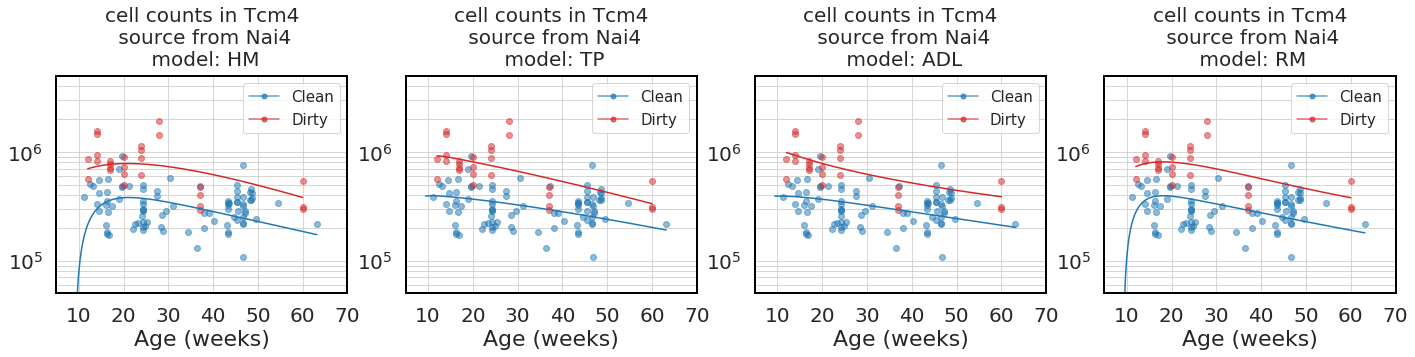

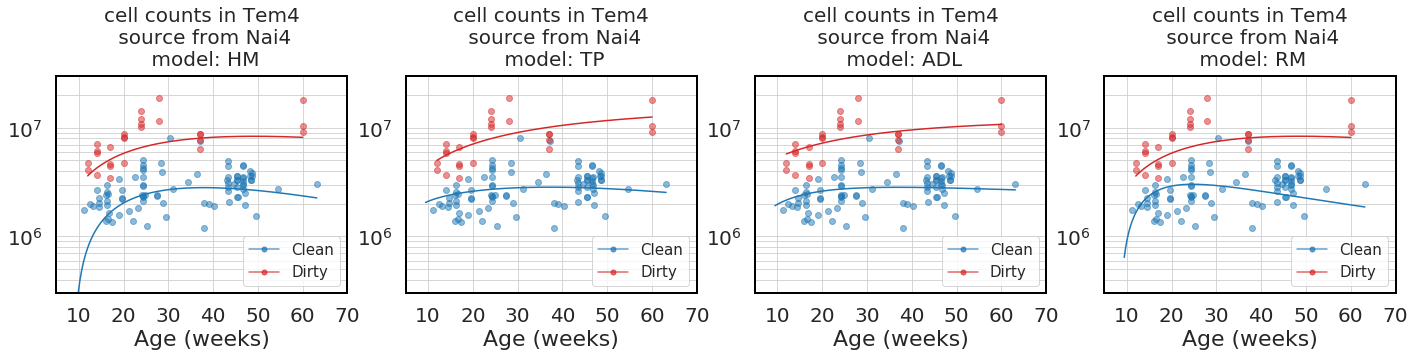

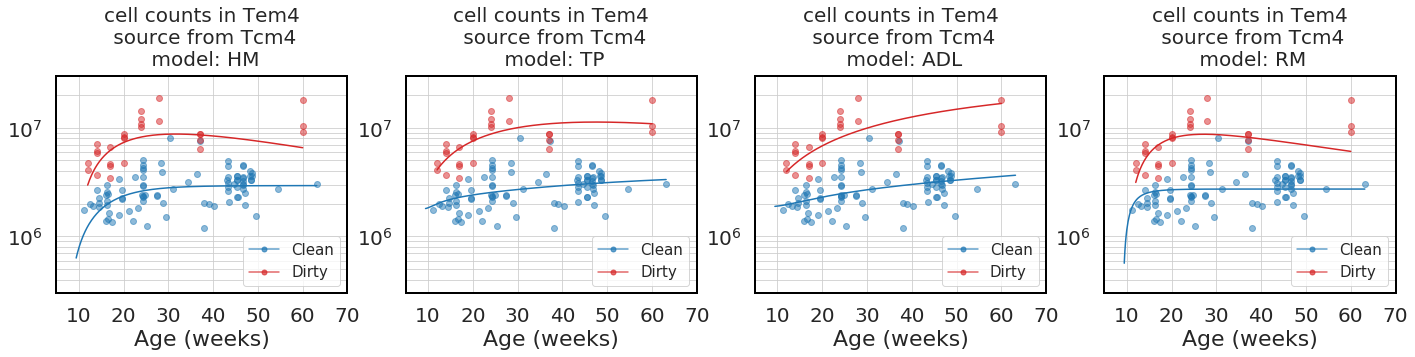

In [74]:
'''
Here we plot cell counts for each model and each target/source combination under consideration.
'''
plot_fits_CC('Tcm4', 'Nai4')
plot_fits_CC('Tem4', 'Nai4')
plot_fits_CC('Tem4', 'Tcm4')

In [43]:
def makeResPredCurves_givenBMT(targetModelType,sourceModelType, target, 
                               targetParams, sourceParams, data, ageBMT_):
    '''
    We treat the source as changing with age, therefore 
    there is a slightly different curve for every age at BMT.
    To visualise the fits to data from the clean facility 
    we partitioned the mice into four groups based on age at BMT,
    and plotted the model predictions for the median age at BMT within each group.
    This function works as makeResPredCurves_model function but for specific age @ BMT.
    Reffer to makeResPredCurves_model for detail explanation of each step.
    '''
    SourceTparams, SourceCHIparams = sourceParams
    CHIDictageBMT = {}
    
    maxage = np.max(data['age'])
    mindpBMT = np.min(data['dpBMT'])
    maxdpBMT = np.max(data['dpBMT'])
    minageBMT = np.min(data['ageBMT'])
    
    AgeLong = np.arange(minageBMT+mindpBMT, maxage+1, 1)
    Givens = [SourceTparams, SourceCHIparams]
    
    CHI_Time = np.arange(mindpBMT, maxdpBMT+1,1)
    
    if targetModelType == 'HM':
        T_0,  phi, lam = targetParams
        MT = odeint(DerivativesNoCHI_HM, T_0,AgeLong,args=(targetParams, Givens, sourceModelType))
        T_0ageBMT = MT[AgeLong == ageBMT_+mindpBMT][0]
        ageBMTparams = [ phi, lam, ageBMT_ ]   
        OdeSys =odeint(DerivativesCHI_HM,[T_0ageBMT, 0.], CHI_Time, 
                       args = (ageBMTparams,Givens, sourceModelType))
        CHIT = OdeSys.T[1]
        
    if targetModelType == 'TP':
        Mf0, Ms0, phi, gamma, lamF, lamS= targetParams
        MT_No_Chi = odeint(DerivativesNoCHI_TP, [Mf0, Ms0],AgeLong,
                           args=(targetParams, Givens, sourceModelType))    
        Mf = MT_No_Chi.T[0]
        Ms = MT_No_Chi.T[1]
        Mf0ageBMT = Mf[AgeLong == ageBMT_+mindpBMT][0]
        Ms0ageBMT = Ms[AgeLong == ageBMT_+mindpBMT][0]
        ageBMTparams = [Mf0, Ms0, phi, gamma, lamF, lamS ]
        GivensageBMT = [SourceTparams, SourceCHIparams, ageBMT_]
        OdeSys =odeint(DerivativesCHI_TP,[Mf0ageBMT,Ms0ageBMT, 0., 0.],CHI_Time, 
                       args = (ageBMTparams, GivensageBMT, sourceModelType))
        Mf_t = OdeSys.T[0]
        Ms_t = OdeSys.T[1]
        chiMf_t = OdeSys.T[2]
        chiMs_t = OdeSys.T[3]
        MT = Mf_t + Ms_t
        CHIT = chiMf_t*Mf_t/MT+chiMs_t*Ms_t/MT
         
    if targetModelType =='ADL':
        phi, lam0, p , A = targetParams
        ST_0 = sourceModelType(SourceTparams,minageBMT+mindpBMT)
        param = [p, minageBMT+mindpBMT, lam0, A , phi, ST_0,SourceTparams]
        Mtot = []
        for t in AgeLong:
            Mtot.append(Mtotal(t,param,sourceModelType))
        Mtot = np.array(Mtot)
        paramChiBMT = [ageBMT_+mindpBMT, lam0, A , phi, ageBMT_, SourceTparams, SourceCHIparams]           
        CHIT = []
        for dpBMT_ in CHI_Time:
            t_ = dpBMT_+ageBMT_
            Mtotal_t = Mtot[AgeLong == t_][0]      
            CHIT.append(normalised_donor_fraction(t_, paramChiBMT, Mtotal_t, sourceModelType))       
        CHIT = np.array(CHIT)          
    
    if targetModelType == 'RM':
        T_0, I_0, phi, lam = targetParams
        MT = odeint(DerivativesNoCHI_RM, T_0,AgeLong,args=(targetParams, Givens, sourceModelType))   
        T_0ageBMT = MT[AgeLong == ageBMT_+mindpBMT][0]
        ageBMTparams = [I_0, phi, lam, ageBMT_ ]
        OdeSys =odeint(DerivativesCHI_RM,[T_0ageBMT, 0.], CHI_Time, 
                       args = (ageBMTparams,Givens, sourceModelType))
        CHIT = OdeSys.T[1]
      
    CHIDictageBMT.update({ageBMT_: CHIT}) 
    return CHIDictageBMT  

In [75]:
def plot_fits_CHI_UCL(targetPop, sourcePop):  
    '''
    The function plots normalised donor fraction chimerism
    for best fitted parameters given model, target and source 
    for Clean mice (UCL).
    The function uses makeResPredCurves_givenBMT to plot the chimerism
    as a median within 4 groups of observed ages @ BMT.
    The groups are chosen arbitrary but to 'evenly' devide the data between
    these 4 groups.
    '''
    # Import data
    dataAll = import_data_for_fits(xls)
    datNIMR, datUCL = getDataForFit(targetPop, dataAll)
    data = datUCL
    mindpBMT = min(data['dpBMT'].values)
    minageBMT = min(data['ageBMT'].values)
    
    # Choose sourceModelType given source.
    if sourcePop == 'Nai4':
        sourceModelType = expModel 
    if sourcePop == 'Tcm4':
        sourceModelType = logModel 
        
    sourceParams = get_source_pam(sourcePop, 'UCL')
   
    # Define bins for age @ BMT where median over the curves is calculated.
    b1, b2, b3 = [9*7,12*7, 16*7+3]
    
    # Find median ageBMT within each group
    ind1 = np.where(data['ageBMT'].values<b1)[0]
    ageBMT1 = np.median(np.array(data['ageBMT'].values)[list(ind1)])

    ind2a = np.where(data['ageBMT'].values>=b1)[0]
    ind2b = np.where(data['ageBMT'].values<b2)[0]
    ind2 = set(ind2a) - (set(ind2a) - set(ind2b))
    ageBMT2 = np.median(np.array(data['ageBMT'].values)[list(ind2)])
    
    ind3a = np.where(data['ageBMT'].values>=b2)[0]
    ind3b = np.where(data['ageBMT'].values<b3)[0]
    ind3 = set(ind3a) - (set(ind3a) - set(ind3b))
    ageBMT3 = np.median(np.array(data['ageBMT'].values)[list(ind3)])
 
    ind4 = np.where(data['ageBMT'].values>b3)[0]
    ageBMT4 = np.median(np.array(data['ageBMT'].values)[list(ind4)])
    
    ageBMTmed = [ageBMT1, ageBMT2, ageBMT3, ageBMT4]       
    
    # Set colours for each group. 
    colors = [palette[2],palette[1],palette[0],palette[4]]
    
    # Plot chimerism for each model.
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(24,4))
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid(True, which = 'both')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
        ax.tick_params(labelsize = my_axis_fontsize-5, which = 'both', pad = 10)         
        ax.set_xlabel('Age (weeks)', fontsize=22)
        ax.set_xticks([70, 140, 210, 280, 350, 420, 490]) 
        ax.set_xticklabels([10, 20, 30, 40, 50, 60, 70])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1]) 
        ax.set_yticklabels(['0.00', 0.25, '0.50', 0.75, '1.00'])
        ax.set_xlim(5*7,70*7)
        ax.set_ylim(-0.05, 1.05)
        ax.title.set_position([.5, 1.02]) 
        ax.set_title('Chimerism'+targetPop+ ' in UCL', fontsize = my_lab_fontsize)
        ij = 0
        for agebmt in data['ageBMT'].values:
            if agebmt <=b1:
                ax.scatter(data['age'].values[ij], data['NCHI'+targetPop].values[ij], 
                           color = colors[0], alpha = 0.7)
            if agebmt >b1 and agebmt <=b2:
                ax.scatter(data['age'].values[ij], data['NCHI'+targetPop].values[ij], 
                           color = colors[1], alpha = 0.7)
            if agebmt >b2 and agebmt <=b3:
                ax.scatter(data['age'].values[ij], data['NCHI'+targetPop].values[ij], 
                           color = colors[2], alpha = 0.7)
            if agebmt >b3:
                ax.scatter(data['age'].values[ij], data['NCHI'+targetPop].values[ij], 
                           color = colors[3], alpha = 0.7)
            ij = ij+1
    
    targetMT = ['HM', 'TP', 'ADL', 'RM']
    for targetModelType in targetMT:
        pamfitUCL = return_pam_fits(targetPop, sourcePop, 'UCL', targetModelType)
        if targetModelType == 'HM':
            T_0, phi, lam = pamfitUCL
            tarpam = T_0,  phi, lam
            ax = ax1
        if targetModelType == 'TP':
            Ms0, phi, gamma, lamF, lamS = pamfitUCL
            Mf0 = phi*sourceModelType(sourceParams[0],minageBMT+mindpBMT)/(lamF+gamma)
            tarpam = [Mf0, Ms0, phi, gamma, lamF, lamS]
            ax = ax2
        if targetModelType == 'ADL':
            phi, lam0, p , A = pamfitUCL
            tarpam = phi, lam0, p , A 
            ax = ax3
        if targetModelType == 'RM':
            T_0, I_0, phi, lam = pamfitUCL   
            tarpam = T_0, I_0, phi, lam
            ax = ax4
        line = []
        for zi in range(0,len(ageBMTmed)):    
            CHIDict =makeResPredCurves_givenBMT(targetModelType,sourceModelType, targetPop, tarpam, 
                                                    sourceParams, data, ageBMTmed[zi])
            CHImaster=CHIDict[ageBMTmed[zi]]
            CHImaster = np.array(CHImaster)
            chiTime = np.arange(ageBMTmed[zi]+mindpBMT, len(CHImaster)+ageBMTmed[zi]+mindpBMT,1)
            ll, =ax.plot(chiTime, CHImaster, alpha=0.7,color=colors[zi])
            line.append(ll)
        l1,l2,l3,l4 = line
        ax.legend([l1,l2,l3, l4], [r'Age @ BMT $\leq$%s wks'%int(b1/7),
                                       r'Age @ BMT $\in$ (%s, %s] wks'%(int(b1/7),int(b2/7)),
                                       r'Age @ BMT $\in$ (%s, %s] wks'%(int(b2/7),int(b3/7)), 
                                       r'Age @ BMT$>$%s wks'%int(b3/7)],
                                    loc = 4, fontsize = 10, frameon = bool)   
        ax.set_title('Donor cell fraction normalised \n to thymus in '+targetPop+
                     ' from '+sourcePop+'\n @ Clean, model: '+targetModelType, 
                     fontsize = my_lab_fontsize)
    fig.savefig('Chimerism_'+targetPop+sourcePop+'UCL'+'.pdf', format='pdf', bbox_inches='tight')

def plot_fits_CHI_NIMR(targetPop, sourcePop):  
    '''
    The function plots normalised donor fraction chimerism
    for best fitted parameters given model, target and source for Dirty mice (NIMR).
    The function uses makeResPredCurves_givenBMT to plot the chimerism 
    for age @ BMT = 56 days, as it was only age @ BMT observed within the data.
    '''
    # Import data
    dataAll = import_data_for_fits(xls)
    datNIMR, datUCL = getDataForFit(targetPop, dataAll)
    data = datNIMR
    mindpBMT = min(data['dpBMT'].values)
    minageBMT = min(data['ageBMT'].values)
    ageBMTmed = np.mean(data['ageBMT'].values)
    
    # Choose sourceModelType given source.
    if sourcePop == 'Nai4':
        sourceModelType = expModel 
    if sourcePop == 'Tcm4':
        sourceModelType = expModel 
        
    sourceParams = get_source_pam(sourcePop, 'NIMR')
   
    # Plot chimerism for each model.
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(24,4))
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid(True, which = 'both')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
        ax.tick_params(labelsize = my_axis_fontsize-5, which = 'both', pad = 10)         
        ax.set_xlabel('Age (weeks)', fontsize=22)
        ax.set_xticks([70, 140, 210, 280, 350, 420, 490]) 
        ax.set_xticklabels([10, 20, 30, 40, 50, 60, 70])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1]) 
        ax.set_yticklabels(['0.00', 0.25, '0.50', 0.75, '1.00'])
        ax.set_xlim(5*7,70*7)
        ax.set_ylim(-0.05, 1.05)
        ax.title.set_position([.5, 1.02]) 
        ax.scatter(data['age'].values, data['NCHI'+targetPop].values, 
                   color = palette[2], alpha = 0.7)
        
    targetMT = ['HM', 'TP', 'ADL', 'RM']
    for targetModelType in targetMT:
        pamfitNIMR = return_pam_fits(targetPop, sourcePop, 'NIMR', targetModelType)
        if targetModelType == 'HM':
            T_0, phi, lam = pamfitNIMR
            tarpam = T_0,  phi, lam
            ax = ax1
        if targetModelType == 'TP':
            Ms0, phi, gamma, lamF, lamS = pamfitNIMR
            Mf0 = phi*sourceModelType(sourceParams[0],minageBMT+mindpBMT)/(lamF+gamma)
            tarpam = [Mf0, Ms0, phi, gamma, lamF, lamS]
            ax = ax2
        if targetModelType == 'ADL':
            phi, lam0, p , A = pamfitNIMR
            tarpam = phi, lam0, p , A 
            ax = ax3
        if targetModelType == 'RM':
            T_0, I_0, phi, lam = pamfitNIMR   
            tarpam = T_0, I_0, phi, lam
            ax = ax4
            
        CHIDict =makeResPredCurves_givenBMT(targetModelType,sourceModelType, targetPop, tarpam, 
                                                sourceParams, data, ageBMTmed)
        CHImaster=CHIDict[ageBMTmed]
        CHImaster = np.array(CHImaster)
        chiTime = np.arange(ageBMTmed+mindpBMT, len(CHImaster)+ageBMTmed+mindpBMT,1)
        ll, =ax.plot(chiTime, CHImaster, alpha=0.7,color=palette[2])  
        ax.legend([ll], [r'Age @ BMT=%s wks'%int(ageBMTmed/7)],loc = 4, fontsize = 15, frameon = bool)
        ax.set_title('Donor cell fraction normalised \n to thymus in '+targetPop+
                     ' from '+sourcePop+'\n @ Dirty, model: '+targetModelType, fontsize = my_lab_fontsize)
    fig.savefig('Chimerism_'+targetPop+sourcePop+'NIMR'+'.pdf', format='pdf', bbox_inches='tight')

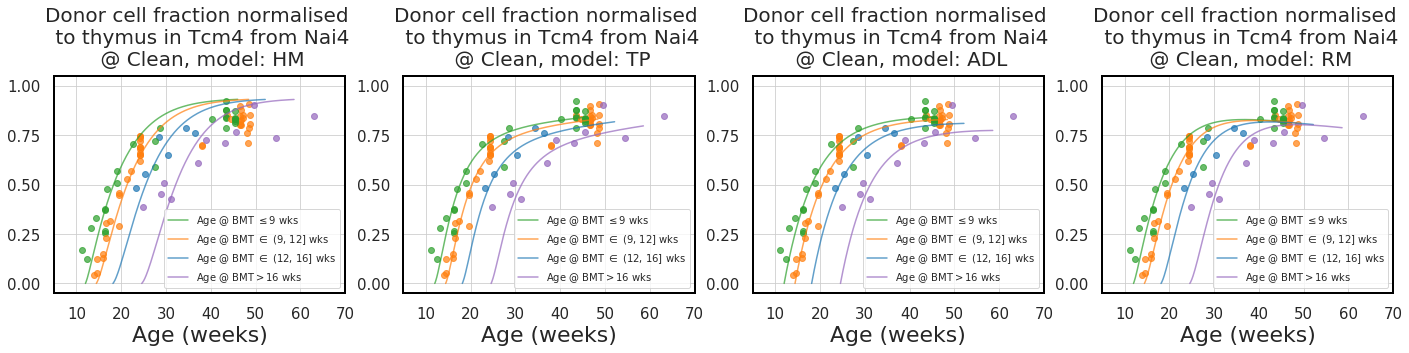

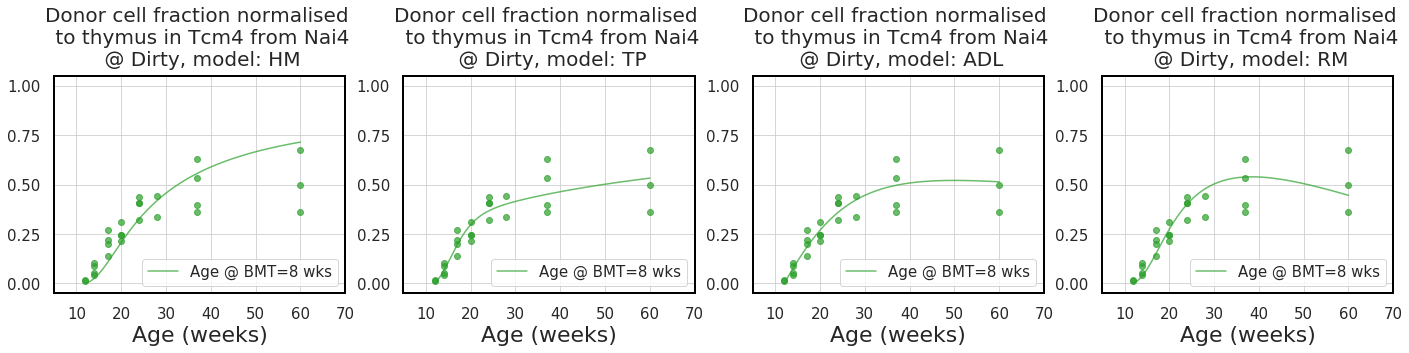

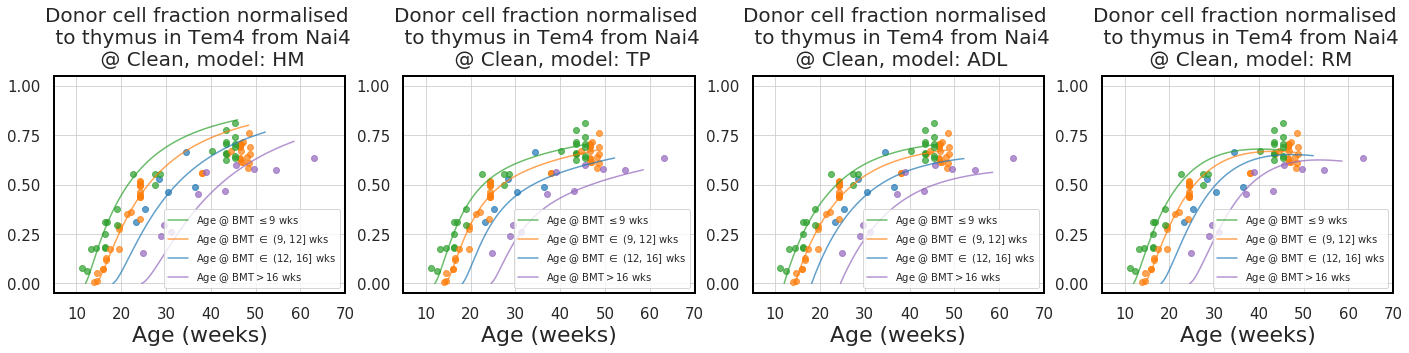

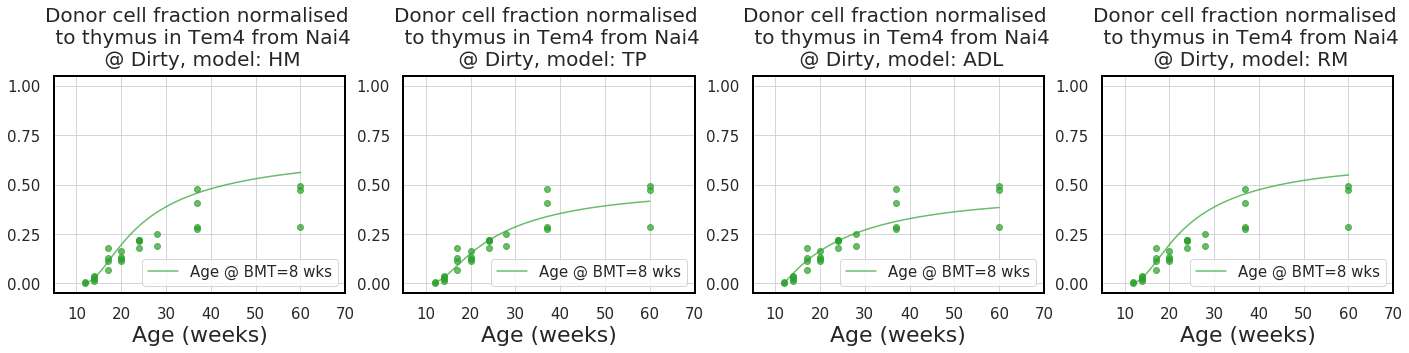

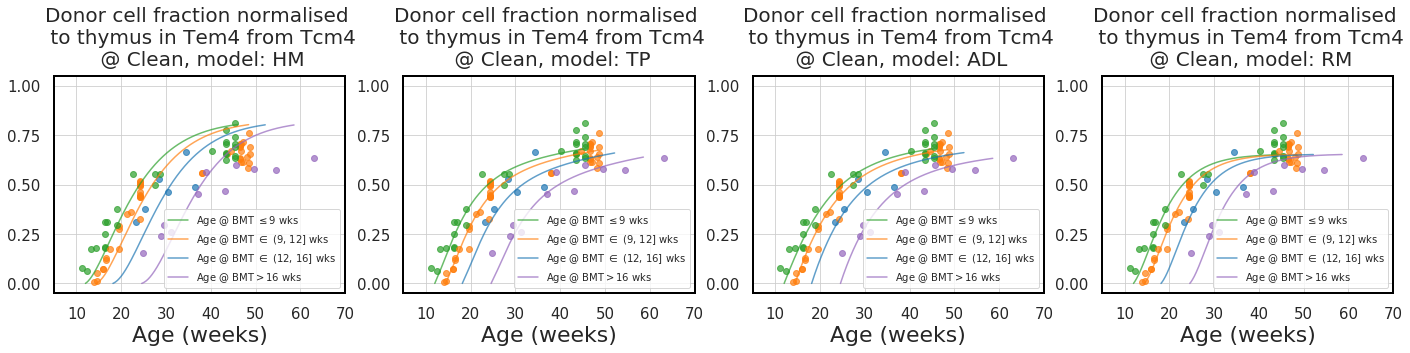

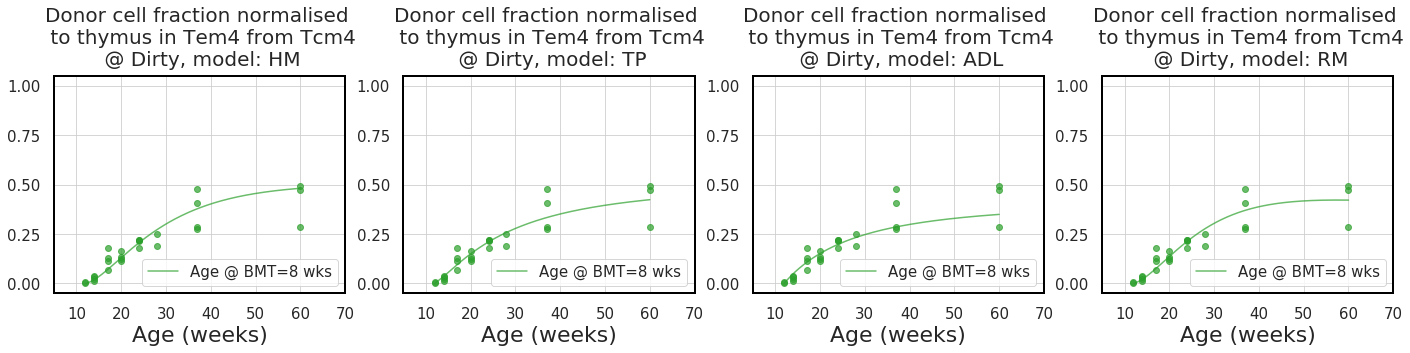

In [76]:
'''
Here we plot chimerism for each model and each target/source combination under consideration.
'''
plot_fits_CHI_UCL('Tcm4', 'Nai4')
plot_fits_CHI_NIMR('Tcm4', 'Nai4')
plot_fits_CHI_UCL('Tem4', 'Nai4')
plot_fits_CHI_NIMR('Tem4', 'Nai4')
plot_fits_CHI_UCL('Tem4', 'Tcm4')
plot_fits_CHI_NIMR('Tem4', 'Tcm4')

# Predict ontogeny

In [77]:
'''
In this section we upload the sheet with data of the cell counts in WT young mice
in naive CD4, central and effector memory CD4.
We fit the splines to naive CD4 and central memory CD4 to later
use it as a source for central and effector memory CD4, respectively.   
'''
def import_data_ontogeny_WT_cc(xls): 
    '''
    The function creates the dataframe from master file
    with cell counts of the naive CD4, central and effector memory CD4
    from WT young mice @ UCL.
    '''
    dfchimeras = xls.parse('WT UCL young mice data')
    dfchimeras = dfchimeras[['Mouse age (days)',
                             'Naive CD4 cell counts',
                             'Central memory CD4 cell counts',
                             'Effector memory CD4 cell counts' ]]
    # Rename the columns for simplicity
    dfchimeras.rename(columns = {'Mouse age (days)':'age',
                                 'Naive CD4 cell counts':'TotalNai4',
                                 'Central memory CD4 cell counts':'TotalTcm4',
                                 'Effector memory CD4 cell counts':'TotalTem4'},
                      inplace=True)
    
    # Add some columns with log of total counts.
    # Later we will fit to log cell counts.
    for col in ['TotalNai4','TotalTcm4', 'TotalTem4']:
        dfchimeras['log'+col] = np.log(dfchimeras[col].values)
    return(dfchimeras)

#import_data_ontogeny_WT_cc(xls)

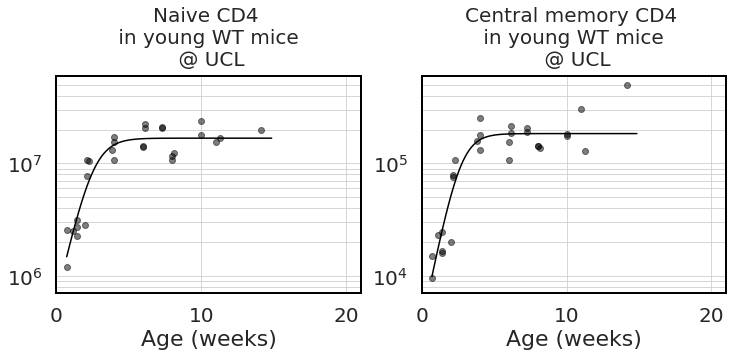

In [79]:
'''
In this section we fit splines for data in young mice
in naive CD4 and central memory CD4 cell counts
from WT animals held in UCL facility.
'''
def TlogResidualsFuncOnto(transParams, t, logObs):
    '''
    The function returns residuals between observed
    cell counts and the predictions in log scale.
    '''
    rawParams = source_cell_TransParamsToRaw(transParams,  logModel)
    model = logModel(rawParams, t)
    residuals = logObs - np.log(model)
    return residuals

def estimateSourceCountsOnto(data, sourcePop,paramsGuess):
    '''
    The funcion uses least_squares with methood trf='Trust Region Reflective'
    to estimate parameter values when fitting data from young mice.
    '''
    logT = data['log'+sourcePop].values
    age = data['age'].values
    transParamsGuess = source_cell_RawParamsToTrans(paramsGuess, logModel)
    Tresult = least_squares(TlogResidualsFuncOnto, transParamsGuess, loss='soft_l1', 
                            method='trf', args=(age, logT))
    transParamsHat = Tresult['x']
    paramsHat = source_cell_TransParamsToRaw(transParamsHat, logModel)
    return paramsHat

def fit_spline_onto(verbose = True):
    '''
    The function returns values of fitted parameters for splines
    for naive and central memory CD4 cell counts in young mice.
    If verbose == True the plot is generated.
    '''
    data = import_data_ontogeny_WT_cc(xls) 
    
    pamNaive= estimateSourceCountsOnto(data, 'TotalNai4',[10**6,10**8,0.01 ])
    pamTcm= estimateSourceCountsOnto(data, 'TotalTcm4',[10**4,10**5,0.01 ])
  
    if verbose:
        Time =  np.arange(5, 15*7,1)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
        for ax in [ax1, ax2]:
            ax.grid(True, which = 'both')
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_color('k')  
                ax.spines[axis].set_linewidth(2)
                ax.set_yscale('log')
            ax.tick_params(labelsize = my_axis_fontsize, which = 'both', pad = 10)    
            ax.title.set_position([.5, 1.02]) 
            ax.set_xlabel('Age (weeks)', fontsize=22)
            ax.set_xticks([0,70, 140, 210, 280, 350, 420, 490]) 
            ax.set_xticklabels([0,10,20,30,40,50,60,70])
            ax.set_xlim(0, 21*7)

        ax1.scatter(data['age'].values,data['TotalNai4'].values, color='k' , alpha = 0.5, label = ' WT')
        ax1.set_ylim(7*10**5, 6*10**7)
        ax1.plot(Time, logModel(pamNaive, Time), color='k' )
        ax1.set_title('Naive CD4 \n in young WT mice \n @ UCL', fontsize = 20)

        ax2.scatter(data['age'].values,data['TotalTcm4'].values, color='k' , alpha = 0.5, label = ' WT')
        ax2.plot(Time, logModel(pamTcm, Time), color='k' )
        ax2.set_ylim(7*10**3, 6*10**5)
        ax2.set_title('Central memory CD4 \n in young WT mice \n @ UCL', fontsize = 20)

        fig.savefig('onto_source_fits.pdf', format='pdf', bbox_inches='tight')
    return pamNaive, pamTcm
res = fit_spline_onto(verbose = True)

In [80]:
'''
In this section we use HM, TP and ADL models to predict 
cell counts in central and effector memory CD4 early in life. 
We assume central memory CD4 are sourced from naive CD4
and effector memory are sourced from central memory 
(the one we predict).
We also assume that initial number of cells @ TCM or TEM CD4
is equal to mean number observed @ t = 5days from data (UCL WT young).
'''

def check_onto_tcm(loc):  
    '''
    The function finds prediction for central memory CD4
    cell counts for HM, TP and ADL models using 
    parameters fitted before at location = loc 
    (loc = 'UCL' or 'NIMR').
    RM does not work nice with the ontogeny idea 
    due to Incumbent memory formation process
    which is not explained by proposed model. 
    '''
    # Import data  
    dataOnto = import_data_ontogeny_WT_cc(xls)
    ind = np.where(dataOnto['age'] == min(dataOnto['age'].values))[0]
    iniCC = np.mean(dataOnto['TotalTcm4'][ind])

    # Define age range
    Time =  np.arange(5, 15*7+1,1)
    
    # Get parameter fits for naive CD4 spline.
    ontoSpams = fit_spline_onto(verbose = False)
    onto_source_pams = ontoSpams[0]

    # Find prediction assuming model = HM
    pam = return_pam_fits('Tcm4', 'Nai4', loc, 'HM')
    T_0, phi,  lam = pam
    tarpam = iniCC, phi, lam
    Givens = [onto_source_pams, 0]
    Mthm = odeint(DerivativesNoCHI_HM,iniCC,Time,
                  args=(tarpam, Givens,logModel))     
    
    # Find prediction assuming model = TP
    pam = return_pam_fits('Tcm4', 'Nai4', loc, 'TP')
    Ms0, phi, gamma, lamF, lamS, = pam
    Mf0 = 0.5*iniCC
    Ms0 = 0.5*iniCC
    tarpam = Mf0, Ms0, phi, gamma, lamF, lamS
    Givens = [onto_source_pams, 0]
    newcur = odeint(DerivativesNoCHI_TP,  [Mf0, Ms0],Time,
                    args=(tarpam, Givens, logModel))
    Mttp = newcur.T[0] + newcur.T[1]
    
    # Find prediction assuming model = ADL
    pam = return_pam_fits('Tcm4', 'Nai4', loc, 'ADL') 
    phi, lam0, p , A = pam
    ST_0 = iniCC*p/(phi*(np.exp(p*5)-1))
    param = [p, 5, lam0, A , phi, ST_0,onto_source_pams]
    Mtadl = []
    for t in Time:
        Mtadl.append(Mtotal(t,param,logModel ))
    Mtadl = np.array(Mtadl)

    return Time, Mtadl, Mttp, Mthm

'''
Here we need to define derivetives for effector memory CD4
assuming that these cells are sourced from central memory CD4
described by curves generated by function check_onto_tcm(loc).
'''

def DerivativesNoCHI_HM_ontoTem(y, Time, params, givens):
    T_t = y
    TimeTcm, MtTcm = givens
    T_0, phi, lam= params 
    ind_time = np.where(TimeTcm == int(Time))[0][0]
    SourceT_t = MtTcm[ind_time]
    dT_dt = phi * SourceT_t - lam * T_t
    return dT_dt

def DerivativesNoCHI_TP_ontoTem(y, Time, params, givens):
    Mf_t, Ms_t = y 
    TimeTcm, MtTcm = givens
    ind_time = np.where(TimeTcm == int(Time))[0][0]
    SourceM_t = MtTcm[ind_time]
    Mf0, Ms0, phi, gamma, lamF, lamS = params 
    dMf_t = phi*SourceM_t - lamF*Mf_t-gamma*Mf_t
    dMs_t = gamma*Mf_t - lamS*Ms_t
    return np.array([dMf_t, dMs_t])

def Mtheta_ontoTem(a,t,param, givens):
    lam0, A , phi= param
    param_lam = [lam0, A]
    TimeTcm, MtTcm = givens
    ind_time = np.where(TimeTcm == int(t-a))[0][0]
    Source = MtTcm[ind_time]
    return phi*Source*np.exp(-integral_fun(fun_lam, 0, a, param_lam))

def Mtotal_ontoTem(t,param, givens):
    p, t0, lam0, A , phi, ST_0  = param
    param_Minit = [ST_0, phi, p, t0, lam0, A]
    param_Mtheta = [lam0, A , phi]
    int1 = integral_fun(Minit, t-t0,t, (t, param_Minit))
    int2 = integral_fun(Mtheta_ontoTem,0,t-t0, (t, param_Mtheta, givens))
    return int1+int2

def check_onto_tem(loc, TimeTcm, MtTcm):  
    '''
    The function finds prediction for effector memory CD4
    cell counts for HM, TP and ADL models using 
    parameters fitted before at location = loc 
    (loc = 'UCL' or 'NIMR').
    As a source it use the curve given by MtTcm 
    @ times TimeTcm.
    RM does not work nice with the ontogeny idea 
    due to Incumbent memory formation process
    which is not explained by proposed model. 
    '''    
    # Import data
    dataOnto = import_data_ontogeny_WT_cc(xls)
    ind = np.where(dataOnto['age'] == min(dataOnto['age'].values))[0]
    iniCC = np.mean(dataOnto['TotalTem4'][ind])
    
    # Define age range
    Time =  np.arange(5, 15*7,1)

    # Find prediction assuming model = HM
    pam = return_pam_fits('Tem4', 'Tcm4', loc, 'HM')
    T_0, phi,  lam = pam
    tarpam = iniCC, phi, lam
    Givens = [TimeTcm, MtTcm]
    Mthm = odeint(DerivativesNoCHI_HM_ontoTem,  iniCC,Time,args=(tarpam, Givens))         

    # Find prediction assuming model = TP
    pam = return_pam_fits('Tem4', 'Tcm4', loc, 'TP')
    Ms0, phi, gamma, lamF, lamS, = pam
    Mf0 = 0.5*iniCC
    Ms0 = 0.5*iniCC
    tarpam = Mf0, Ms0, phi, gamma, lamF, lamS
    Givens = [TimeTcm, MtTcm]
    newcur = odeint(DerivativesNoCHI_TP_ontoTem,  [Mf0, Ms0],Time,args=(tarpam, Givens))
    Mttp = newcur.T[0] + newcur.T[1]    
    
    # Find prediction assuming model = ADL
    pam = return_pam_fits('Tem4', 'Tcm4', loc, 'ADL')
    phi, lam0, p , A = pam
    ST_0 = iniCC*p/(phi*(np.exp(5*p)-1))
    param = [p, 5, lam0, A , phi, ST_0]
    Givens = [TimeTcm, MtTcm]
    Mtadl = []
    for t in Time:
        Mtadl.append(Mtotal_ontoTem(t,param,Givens ))
    Mtadl = np.array(Mtadl)
       
    return Time, Mtadl, Mttp, Mthm

In [86]:
def check_onto_fits(loc, sourceModel):  
    '''
    The function plots predicted curves for cell counts 
    in central and effector memory in young mice.
    Here we assume that the source for effector memory CD4
    cell counts is given by central memory prediction
    described using model = sourceModel.
    '''
    # Find prediction curve for central memory.
    TimeTcm, MtadlTcm, MttpTcm, MthmTcm = check_onto_tcm(loc)
    # Get rid off double brackets here.
    MthmTcm = np.squeeze(MthmTcm)
    
    # Given chosen model find predction for effector memory
    if sourceModel == 'HM':
        TimeTem, MtadlTem, MttpTem, MthmTem = check_onto_tem(loc,TimeTcm, MthmTcm)
    if sourceModel == 'ADL':
        TimeTem, MtadlTem, MttpTem, MthmTem = check_onto_tem(loc,TimeTcm, MtadlTcm)
    if sourceModel == 'TP':
        TimeTem, MtadlTem, MttpTem, MthmTem = check_onto_tem(loc,TimeTcm, MttpTcm)        

    # Import data for chimeric adult mice.
    dataAll = import_data_for_fits(xls)
    datNIMRTcm, datUCLTcm = getDataForFit('Tcm4', dataAll)
    datNIMRTem, datUCLTem = getDataForFit('Tem4', dataAll)
    if loc == 'UCL':
        dataChiTcm = datUCLTcm
        dataChiTem = datUCLTem
        pal = 0
    if loc == 'NIMR':
        dataChiTcm = datNIMRTcm
        dataChiTem = datUCLTem
        pal = 3 
        
    # Import data for young, WT, UCL mice.
    dataOnto = import_data_ontogeny_WT_cc(xls)

    # Plot central and effector memory predictions.
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,4))  
    ax1.scatter(dataChiTcm['age'].values,dataChiTcm['Total'+'Tcm4'].values, 
                color=palette[pal], alpha = 0.5, label = 'Chimera '+loc)
    ax1.scatter(dataOnto['age'].values,dataOnto['Total'+'Tcm4'].values, 
                color='k', alpha = 0.5, label = ' WT UCL')

    ax2.scatter(dataChiTem['age'].values,dataChiTem['Total'+'Tem4'].values, 
                color=palette[pal], alpha = 0.5, label = 'Chimera '+loc)
    ax2.scatter(dataOnto['age'].values,dataOnto['Total'+'Tem4'].values, 
                color='k',alpha = 0.5, label = ' WT UCL')    
        
    ax1.plot(TimeTcm , MtadlTcm, color=palette[1], label = 'ADL')    
    ax1.plot(TimeTcm, MttpTcm, color = palette[2] , label = 'TP')
    ax1.plot(TimeTcm, MthmTcm, color=palette[3], label = 'HM' )

    ax2.plot(TimeTem , MtadlTem, color=palette[1], label = 'ADL')    
    ax2.plot(TimeTem, MttpTem, color = palette[2] , label = 'TP')
    ax2.plot(TimeTem, MthmTem, color=palette[3], label = 'HM' )    
   
    ax1.set_ylim(3*10**3, 3*10**6)
    ax2.set_ylim(10**4, 6*10**6)
    
    for ax in [ax1, ax2]:
        ax.grid(True, which = 'both')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
            ax.set_yscale('log')
        ax.tick_params(labelsize = my_axis_fontsize, which = 'both', pad = 10)    
        ax.title.set_position([.5, 1.02]) 
        ax.set_xlabel('Age (weeks)', fontsize=22)
        ax.set_xticks([0,70, 140, 210, 280, 350, 420, 490]) 
        ax.set_xticklabels([0,10,20,30,40,50,60,70])
        ax.set_xlim(0, 21*7)
    ax2.legend(loc = 4, fontsize = 15, frameon = bool, bbox_to_anchor=(1.7,0.2)) 
    ax1.set_title('Tcm4 @ '+loc+'\n source naive CD4 \n described by spline', fontsize=20)
    ax2.set_title('Tem4 @ '+loc+'\n source central memory CD4'+'\n described by model '+sourceModel, fontsize=20)
    fig.savefig('pred_back_All'+loc+sourceModel+'.pdf', format='pdf', bbox_inches='tight')

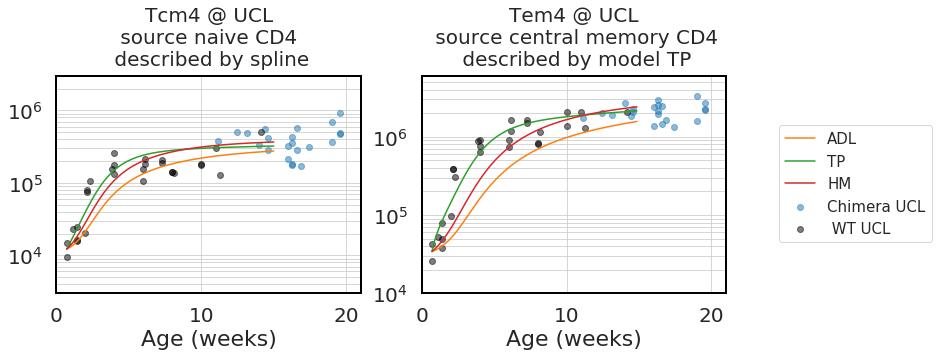

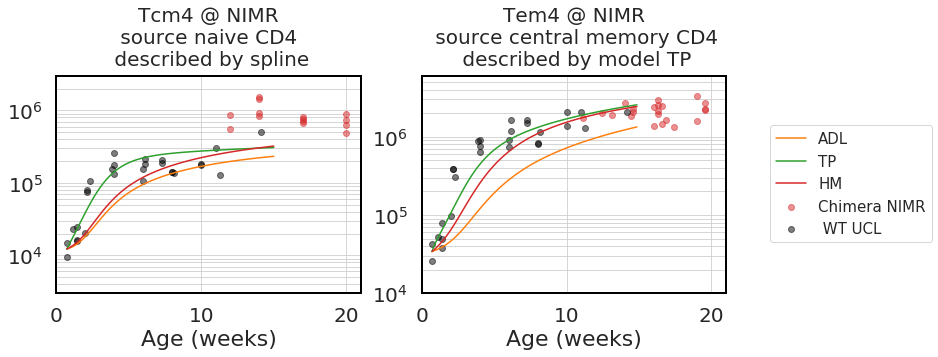

In [87]:
check_onto_fits('UCL', 'TP')
check_onto_fits('NIMR', 'TP')

# Analysis of GF/NIMR/UCL data early in life

In [88]:
def import_data_diff_loc(xls): 
    '''
    The function creates the dataframe from master file
    with cell counts of the naive CD4, central and effector memory CD4
    from WT young mice @ UCL.
    '''
    dfchimeras = xls.parse('GF, NIMR, UCL, Oxford mice cell counts and KI67 expression')
    dfchimeras = dfchimeras[['Location and mouse type','Mouse age (days)',
                             'Central memory CD4 cell counts',
                             'Effector memory CD4 cell counts',
                             'Central memory CD4 Ki67 expression',
                             'Effector memory CD4 Ki67 expression']]
    # Rename the columns for simplicity
    dfchimeras.rename(columns = {'Location and mouse type':'exptlocation',
                                 'Mouse age (days)':'age',
                                 'Central memory CD4 cell counts':'TotalTcm4',
                                 'Effector memory CD4 cell counts':'TotalTem4',
                                 'Central memory CD4 Ki67 expression':'Ki67Tcm4',
                                 'Effector memory CD4 Ki67 expression':'Ki67Tem4'},
                      inplace=True)
    
    # Add some columns with log of total counts.
    # Later we will fit to log cell counts.
    for col in ['TotalTcm4', 'TotalTem4']:
        dfchimeras['log'+col] = np.log(dfchimeras[col].values)
    return(dfchimeras)

#import_data_diff_loc(xls)

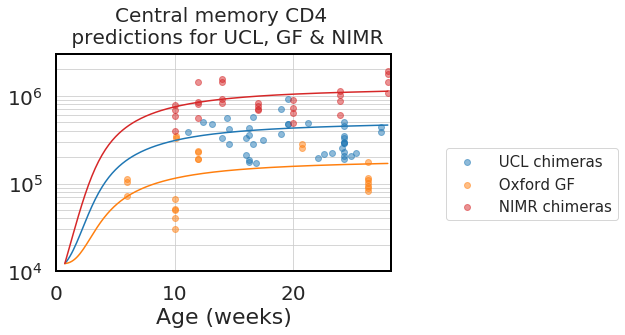

In [109]:
'''
In this section we check what change in force of recruitment
we need to make in order to predict cell counts 
in central memory CD4 in adult mice using ADL model
in germ-free (GF), UCL or NIMR facility.
'''

def crossResiduals_dirt(transTargetParams,*mycoeff):
    '''
    The function returns AIC value calculated from
    residuals between predictions and observed data.
    Here we assume that predictions have to be
    as close as possible to mean value from data
    between 11-28 weeks @ age = 11 weeks. 
    '''
    fittedPams, Givens, datt, datc = mycoeff
    fact = np.exp(transTargetParams[0])
    
    # Predict cell counts given parameters
    # @ t = 11 weeks
    onto_source_pams, iniCC = Givens
    phi, lam0, p , A = fittedPams
    phi = phi*fact
    ST_0 = iniCC*p/(phi*(np.exp(p*5)-1))
    tarpamGF = [p, 5, lam0, A , phi, ST_0,onto_source_pams]
    t = 11*7
    Mtadl = Mtotal(t,tarpamGF,logModel )
    Mtadl = np.array(Mtadl)
    
    # Find residuals
    resi = []
    for i in range(0, len(datt)):
        resi.append(np.log(datc[i]) - np.log(Mtadl))
    resi = np.array(resi) 
    
    # Find AIC
    logL = logLR(resi)
    AIC = aic(logL, 1, len(resi))
    return AIC

def fit_GF_NIMR_UCL_Tcm(verbose = True):
    '''
    The function finds factor change in force of recruitment 
    phi needed to predict cell counts in central memory CD4
    in GF, UCL and NIMR.
    Factor factUCL is caluclated for UCL first, then
    the algorithm look for factor change for GF and NIMR
    to factUCL*phi.
    '''
    # Import data and define dataframe
    # for GF, UCL and NIMR cell counts.
    data=import_data_diff_loc(xls)
    
    indloc = data['exptlocation'] == 'Oxford GF'
    dataGF = data.copy()
    dataGF = dataGF.loc[indloc, :]
    dataGF = dataGF.reset_index(drop=True)      

    indloc = data['exptlocation'] == 'NIMR chimera'
    dataNIMR = data.copy()
    dataNIMR = dataNIMR.loc[indloc, :]
    dataNIMR = dataNIMR.reset_index(drop=True)  
    
    data = import_data_for_fits(xls)
    indloc = data['exptlocation'] == 'UCL chimera'
    dataUCL = data.copy()
    dataUCL = dataUCL.loc[indloc, :]
    dataUCL = dataUCL.reset_index(drop=True)  

    # Get source fit parameters.
    ontoSpams = fit_spline_onto(verbose = False)
    onto_source_pams = ontoSpams[0]
    
    # Find initial value for cell counts
    # assuming it is similar to mean from data (WT UCL).
    dataOnto = import_data_ontogeny_WT_cc(xls)
    ind = np.where(dataOnto['age'] == min(dataOnto['age'].values))[0]
    iniCC = np.mean(dataOnto['TotalTcm4'][ind])
    
    # Get parameter values for ADL model
    pam = return_pam_fits('Tcm4', 'Nai4', 'UCL', 'ADL')
    Givens = [onto_source_pams, iniCC]
    Time = np.arange(5, 28*7+1,1)
    
    # Fit UCL data 
    # Take data only up to 28 weeks of age.
    indage = np.where(dataUCL['age'].values<28*7)
    datt = dataUCL['age'].values[indage]
    datc = dataUCL['TotalTcm4'].values[indage]
    popIndex = np.logical_not(np.isnan(datc))
    datc = datc[popIndex]
    datt = datt[popIndex] 
    
    # Fit factUCL
    factGuess = 1.5
    transParamsGuess = np.log(factGuess)
    result = minimize(fun=crossResiduals_dirt, args=(pam, Givens, datt, datc),
                      x0 = transParamsGuess, method='Nelder-Mead', options={'disp': False})
    transParamsHat = result['x']
    factFitUCL = np.exp(transParamsHat[0])
    
    # Predict central memory CD4 cell counts
    # given phi = phi*factUCL
    phi, lam0, p, A = pam
    param = [phi*factFitUCL, lam0, p, A]
    ST_0 = iniCC*p/(phi*factFitUCL*(np.exp(p*5)-1))
    param = [p, 5, lam0, A , phi*factFitUCL, ST_0,onto_source_pams]
    MtUCL = []
    for t in Time:
        MtUCL.append(Mtotal(t,param,logModel ))
    MtUCL = np.array(MtUCL)
    
    # Fit GF data 
    # Take data only between 10 and 28 weeks of age.
    indageh = dataGF['age'].values<28*7
    indagel = dataGF['age'].values>9*7
    indage = indageh & indagel
    dd = dataGF.copy()
    dd = dd.loc[indage, :]
    dd = dd.reset_index(drop=True)
    datt = dd['age'].values
    datc = dd['TotalTcm4'].values
    popIndex = np.logical_not(np.isnan(datc))
    datc = datc[popIndex]
    datt = datt[popIndex] 
    
    # Fit factGF assuming that we start from 
    # adjusted phi = phi*factUCL
    pam = [phi*factFitUCL, lam0, p, A]
    factGuess = 0.5
    transParamsGuess = np.log(factGuess)   
    result = minimize(fun=crossResiduals_dirt, args=(pam, Givens, datt, datc),
                      x0 = transParamsGuess, method='Nelder-Mead', options={'disp': False})
    transParamsHat = result['x']
    factFitGF = np.exp(transParamsHat[0])
     
    # Predict central memory CD4 cell counts
    # given phi = phi*factUCL*factGF    
    param = [phi*factFitGF*factFitUCL, lam0, p, A]
    ST_0 = iniCC*p/(phi*factFitGF*factFitUCL*(np.exp(p*5)-1))
    param = [p, 5, lam0, A , phi*factFitGF*factFitUCL, ST_0,onto_source_pams]
    MtGF = []
    for t in Time:
        MtGF.append(Mtotal(t,param,logModel ))
    MtGF = np.array(MtGF)
       
    # Fit NIMR data 
    # Take data only up to 28 weeks of age.
    indage = np.where(dataNIMR['age'].values<28*7)
    datt = dataNIMR['age'].values[indage]
    datc = dataNIMR['TotalTcm4'].values[indage]
    popIndex = np.logical_not(np.isnan(datc))
    datc = datc[popIndex]
    datt = datt[popIndex] 
    
    # Fit factNIMR assuming that we start from 
    # adjusted phi = phi*factUCL    
    factGuess = 2.1
    transParamsGuess = np.log(factGuess)
    result = minimize(fun=crossResiduals_dirt, args=(pam, Givens, datt, datc),
                      x0 = transParamsGuess, method='Nelder-Mead', options={'disp': False})
    transParamsHat = result['x']
    factFitNIMR = np.exp(transParamsHat[0])
    
    # Predict central memory CD4 cell counts
    # given phi = phi*factUCL*factNIMR      
    param = [phi*factFitUCL*factFitNIMR, lam0, p, A]
    ST_0 = iniCC*p/(phi*factFitUCL*factFitNIMR*(np.exp(p*5)-1))
    param = [p, 5, lam0, A , phi*factFitUCL*factFitNIMR, ST_0,onto_source_pams]
    MtNIMR = []
    for t in Time:
        MtNIMR.append(Mtotal(t,param,logModel ))
    MtNIMR = np.array(MtNIMR)    
    
    if verbose:
        fig, ax = plt.subplots()
        ax.grid(True, which = 'both')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
            ax.set_yscale('log')
        ax.tick_params(labelsize = my_axis_fontsize, which = 'both', pad = 10)    
        ax.title.set_position([.5, 1.02]) 
        ax.scatter(dataUCL['age'].values,dataUCL['TotalTcm4'].values, color=palette[0],
                   alpha = 0.5, label = ' UCL chimeras')
        ax.scatter(dataGF['age'].values,dataGF['TotalTcm4'].values, color=palette[1],
                   alpha = 0.5, label = ' Oxford GF')
        ax.scatter(dataNIMR['age'].values,dataNIMR['TotalTcm4'].values, color=palette[3],
                   alpha = 0.5, label = ' NIMR chimeras')

        ax.plot(Time, MtUCL, color=palette[0] )
        ax.plot(Time, MtGF, color=palette[1] )
        ax.plot(Time, MtNIMR, color=palette[3] )    
        ax.set_xlabel('Age (weeks)', fontsize=22)
        ax.set_xticks([0,70, 140, 210, 280, 350, 420, 490]) 
        ax.set_xticklabels([0,10,20,30,40,50,60,70])
        ax.legend(loc = 4, fontsize = 15, frameon = bool, bbox_to_anchor=(1.7,0.2))
        ax.set_ylim(10**4, 3*10**6)
        ax.set_xlim(0, 28*7+2)
        ax.set_title('Central memory CD4 \n predictions for UCL, GF & NIMR', fontsize = 20)
        fig.savefig('pred_back_GF_UCL_NIMR_Tcm.pdf', format='pdf', bbox_inches='tight')
    return Time, MtUCL, MtGF, MtNIMR

res = fit_GF_NIMR_UCL_Tcm()

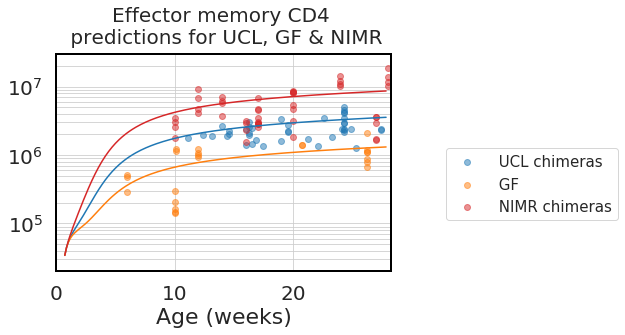

In [117]:
'''
In this section we check predict cell counts 
in effector memory CD4 in adult mice using TP model
in germ-free (GF), UCL or NIMR facility,
and as a source corrected predictions from central
memory CD4 from previous section.
'''
def fit_GF_NIMR_UCL_Tem(verbose = True):
    '''
    The function plots predictions for effector memory CD4
    cell counts assuming the source is generated by
    fit_GF_NIMR_UCL_Tcm('Nai4', 'Tcm4', verbose = False)
    with model ADL.
    '''
    # Import data and define dataframe
    # for GF, UCL and NIMR cell counts.
    data=import_data_diff_loc(xls)
    
    indloc = data['exptlocation'] == 'Oxford GF'
    dataGF = data.copy()
    dataGF = dataGF.loc[indloc, :]
    dataGF = dataGF.reset_index(drop=True)      

    indloc = data['exptlocation'] == 'NIMR chimera'
    dataNIMR = data.copy()
    dataNIMR = dataNIMR.loc[indloc, :]
    dataNIMR = dataNIMR.reset_index(drop=True)  
    
    data = import_data_for_fits(xls)
    indloc = data['exptlocation'] == 'UCL chimera'
    dataUCL = data.copy()
    dataUCL = dataUCL.loc[indloc, :]
    dataUCL = dataUCL.reset_index(drop=True)  

    # Get source prediction
    TimeTcm, MtUCLTcm, MtGFTcm, MtNIMRTcm = fit_GF_NIMR_UCL_Tcm(verbose = False)
    # Find initial value for cell counts
    # assuming it is similar to mean from data (WT UCL).
    dataOnto = import_data_ontogeny_WT_cc(xls)
    ind = np.where(dataOnto['age'] == min(dataOnto['age'].values))[0]
    iniCC = np.mean(dataOnto['TotalTem4'][ind])
    
    # Get parameter values for TP model
    pam = return_pam_fits('Tem4', 'Tcm4', 'UCL', 'TP')
    Time = np.arange(5, 28*7,1)
    
    # Take UCL data only between 10 and 28 weeks of age.
    indage = np.where(dataUCL['age'].values<28*7)
    datt = dataUCL['age'].values[indage]
    datc = dataUCL['TotalTem4'].values[indage]
    popIndex = np.logical_not(np.isnan(datc))
    datc = datc[popIndex]
    datt = datt[popIndex] 
    
    # Predict effector memory CD4 cell counts
    Ms0, phi, gamma, lamF, lamS, = pam
    Mf0 = 0.5*iniCC
    Ms0 = 0.5*iniCC
    tarpam = Mf0, Ms0, phi, gamma, lamF, lamS
    Givens = [TimeTcm, MtUCLTcm]
    newcur = odeint(DerivativesNoCHI_TP_ontoTem,  [Mf0, Ms0],Time,args=(tarpam, Givens))
    MtUCLTem = newcur.T[0] + newcur.T[1]
    
    # Take GF data only between 10 and 28 weeks of age.
    indageh = dataGF['age'].values<28*7
    indagel = dataGF['age'].values>9*7
    indage = indageh & indagel
    dd = dataGF.copy()
    dd = dd.loc[indage, :]
    dd = dd.reset_index(drop=True)
    datt = dd['age'].values
    datc = dd['TotalTem4'].values
    popIndex = np.logical_not(np.isnan(datc))
    datc = datc[popIndex]
    datt = datt[popIndex] 
    
    # Predict effector memory CD4 cell counts
    Ms0, phi, gamma, lamF, lamS, = pam
    Mf0 = 0.5*iniCC
    Ms0 = 0.5*iniCC
    tarpam = Mf0, Ms0, phi, gamma, lamF, lamS
    Givens = [TimeTcm, MtGFTcm]
    newcur = odeint(DerivativesNoCHI_TP_ontoTem,  [Mf0, Ms0],Time,args=(tarpam, Givens))
    MtGFTem = newcur.T[0] + newcur.T[1]       
    
    # Take NIMR data only between 10 and 28 weeks of age.
    indage = np.where(dataNIMR['age'].values<28*7)
    datt = dataNIMR['age'].values[indage]
    datc = dataNIMR['TotalTem4'].values[indage]
    popIndex = np.logical_not(np.isnan(datc))
    datc = datc[popIndex]
    datt = datt[popIndex] 
    
    # Predict effector memory CD4 cell counts
    Ms0, phi, gamma, lamF, lamS, = pam
    Mf0 = 0.5*iniCC
    Ms0 = 0.5*iniCC
    tarpam = Mf0, Ms0, phi, gamma, lamF, lamS
    Givens = [TimeTcm, MtNIMRTcm]
    newcur = odeint(DerivativesNoCHI_TP_ontoTem,  [Mf0, Ms0],Time,args=(tarpam, Givens))
    MtNIMRTem = newcur.T[0] + newcur.T[1]
    
    # Plot prediction if verbose == True 
    if verbose:
        fig, ax = plt.subplots()
        ax.grid(True, which = 'both')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_color('k')  
            ax.spines[axis].set_linewidth(2)
            ax.set_yscale('log')
        ax.tick_params(labelsize = my_axis_fontsize, which = 'both', pad = 10)    
        ax.title.set_position([.5, 1.02]) 
        ax.scatter(dataUCL['age'].values,dataUCL['TotalTem4'].values, color=palette[0],
                   alpha = 0.5, label = ' UCL chimeras')
        ax.scatter(dataGF['age'].values,dataGF['TotalTem4'].values, color=palette[1],
                   alpha = 0.5, label = ' GF')
        ax.scatter(dataNIMR['age'].values,dataNIMR['TotalTem4'].values, color=palette[3],
                   alpha = 0.5, label = ' NIMR chimeras')

        ax.plot(Time, MtUCLTem, color=palette[0] )
        ax.plot(Time, MtGFTem, color=palette[1] )
        ax.plot(Time, MtNIMRTem, color=palette[3] )    
        ax.set_xlabel('Age (weeks)', fontsize=22)
        ax.legend(loc = 4, fontsize = 15, frameon = bool, bbox_to_anchor=(1.7,0.2))
        ax.set_xticks([0,70, 140, 210, 280, 350, 420, 490]) 
        ax.set_xticklabels([0,10,20,30,40,50,60,70])
        ax.set_ylim(2*10**4, 3*10**7)
        ax.set_xlim(0, 28*7+2)
        ax.set_title('Effector memory CD4 \n predictions for UCL, GF & NIMR', fontsize = 20)
        fig.savefig('pred_back_GF_UCL_NIMR_Tem.pdf', format='pdf', bbox_inches='tight')

fit_GF_NIMR_UCL_Tem()